<div style="text-align: center;"> <p style="color: blue; font-size: 40px; font-weight: bold;">Freshwater Potability Assessment and Prediction </p></div>

<div style="text-align: center;"> <img src="waterq3.png" alt="description" width="900"/> </div>

# A Brief

- This is an ML model to predict whether the freshwater is safe to drink or not
- Based on the measures like pH, different checmical available in water, etc

# Import necessary packages and libraries

In [1]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

import matplotlib.gridspec as gridspec
from scipy.stats import pearsonr
from scipy.stats import mannwhitneyu
from scipy import stats

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import calibration_curve

warnings.filterwarnings("ignore")

# Data

In [2]:
chunks = pd.read_csv('dataset.csv', chunksize=10000)
df = []
for chunk in chunks:
    df.append(chunk)    
data = pd.concat(df, ignore_index=False)

In [3]:
print('\nData Dimensions/Structure : ')
print(data.shape, '\n')
print('~' * 100)
print('\nData Columns : ')
print(data.columns, '\n')
print('~' * 100)
print('\nData Info. : ')
print(data.info(), '\n')
print('~' * 100)
print('\nColumn wise Null Values : ')
print(data.isnull().sum(), '\n')


Data Dimensions/Structure : 
(5956842, 24) 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Data Columns : 
Index(['Index', 'pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Color',
       'Turbidity', 'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity',
       'Chlorine', 'Manganese', 'Total Dissolved Solids', 'Source',
       'Water Temperature', 'Air Temperature', 'Month', 'Day', 'Time of Day',
       'Target'],
      dtype='object') 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

Data Info. : 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 24 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Index                   int64  
 1   pH                      float64
 2   Iron                    float64
 3   Nitrate                 float64
 4   Chloride                float64
 5   

In [4]:
print('~' * 100)
print('\n Different colors in Color column : ')
print(data.Color.unique(), '\n')

print('~' * 100)
print('\n Different water sources in Source column : ')
print(data.Source.unique(), '\n')

print('~' * 100)
print('\n Different values on Month column : ')
print(data.Month.unique(), '\n')

print('~' * 100)
print('\n Different days in Day column : ')
print(sorted(data.Day.unique()), '\n')

print('~' * 100)
print('\n Different time of days in Time-of-Day column : ')
print(sorted(data['Time of Day'].unique()), '\n')

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Different colors in Color column : 
['Colorless' 'Faint Yellow' 'Light Yellow' 'Near Colorless' 'Yellow' nan] 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Different water sources in Source column : 
[nan 'Lake' 'River' 'Ground' 'Spring' 'Stream' 'Aquifer' 'Reservoir'
 'Well'] 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Different values on Month column : 
['January' 'November' 'April' 'June' 'March' 'September' 'May' 'July'
 'August' 'October' 'December' 'February' nan] 

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

 Different days in Day column : 
[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0,

## Data statistics

In [5]:
data.describe()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,...,Sulfate,Conductivity,Chlorine,Manganese,Total Dissolved Solids,Water Temperature,Air Temperature,Day,Time of Day,Target
count,5.956842e+06,5.840788e+06,5.917089e+06,5.851117e+06,5.781311e+06,5.929933e+06,5.800716e+06,5.907027e+06,5.767686e+06,5.757440e+06,...,5.759424e+06,5.792981e+06,5.899017e+06,5.847259e+06,5.955172e+06,5.788609e+06,5.927114e+06,5.857239e+06,5.842323e+06,5.956842e+06
mean,2.978420e+06,7.445373e+00,1.279027e-01,6.169970e+00,1.842970e+02,1.498336e-03,1.550255e+00,5.215093e-01,9.644315e-01,5.161216e-01,...,1.460764e+02,4.249974e+02,3.255738e+00,1.092802e-01,2.671454e+02,1.912982e+01,6.000324e+01,1.573227e+01,1.150404e+01,3.030552e-01
std,1.719592e+06,8.881665e-01,4.799915e-01,3.256667e+00,6.842828e+01,3.250641e-02,1.546368e+00,9.258807e-01,8.247870e-01,5.965534e-01,...,6.879844e+01,1.899937e+02,7.328441e-01,4.761827e-01,1.558586e+02,1.136623e+01,1.809977e+01,8.794391e+00,6.922858e+00,4.595789e-01
min,0.000000e+00,1.057113e+00,2.047587e-53,2.861727e-01,2.363919e+01,0.000000e+00,1.482707e-08,1.029712e-16,4.550148e-06,2.982735e-10,...,1.194073e+01,1.059998e+01,9.019921e-01,4.793505e-55,1.048902e-02,6.661938e-01,-3.387091e+01,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.489210e+06,6.894328e+00,9.992949e-06,3.973078e+00,1.381341e+02,1.500283e-122,4.148202e-01,3.872368e-02,3.749503e-01,1.288629e-01,...,9.777114e+01,2.864261e+02,2.744504e+00,2.522376e-06,1.329157e+02,1.134879e+01,4.779120e+01,8.000000e+00,6.000000e+00,0.000000e+00
50%,2.978420e+06,7.449564e+00,2.249640e-03,5.604051e+00,1.760178e+02,2.213625e-62,1.081818e+00,2.097680e-01,7.751792e-01,3.479592e-01,...,1.346489e+02,3.970808e+02,3.209748e+00,6.481943e-04,2.658880e+02,1.644428e+01,5.999681e+01,1.600000e+01,1.200000e+01,0.000000e+00
75%,4.467631e+06,8.014424e+00,5.455290e-02,7.672402e+00,2.179811e+02,3.592165e-27,2.230841e+00,6.249132e-01,1.341508e+00,7.010104e-01,...,1.817703e+02,5.333489e+02,3.705217e+00,1.672082e-02,3.984954e+02,2.383543e+01,7.221235e+01,2.300000e+01,1.800000e+01,1.000000e+00
max,5.956841e+06,1.291072e+01,1.935315e+01,9.639078e+01,1.507310e+03,5.844281e+00,2.836867e+01,2.371527e+01,1.464625e+01,1.207482e+01,...,1.434587e+03,2.271632e+03,1.256663e+01,2.374086e+01,5.797999e+02,2.973086e+02,1.521237e+02,3.100000e+01,2.300000e+01,1.000000e+00


## Summary of missing values in percentage

In [6]:
# Summary Missing values
print("Dataset Shape:", data.shape)
print("\nMissing Values:\n", round(data.isnull().sum()*100/data.shape[0],2))

Dataset Shape: (5956842, 24)

Missing Values:
 Index                     0.00
pH                        1.95
Iron                      0.67
Nitrate                   1.77
Chloride                  2.95
Lead                      0.45
Zinc                      2.62
Color                     0.10
Turbidity                 0.84
Fluoride                  3.18
Copper                    3.35
Odor                      3.00
Sulfate                   3.31
Conductivity              2.75
Chlorine                  0.97
Manganese                 1.84
Total Dissolved Solids    0.03
Source                    1.48
Water Temperature         2.82
Air Temperature           0.50
Month                     1.61
Day                       1.67
Time of Day               1.92
Target                    0.00
dtype: float64


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Plot of data points excluding the missing values : 
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


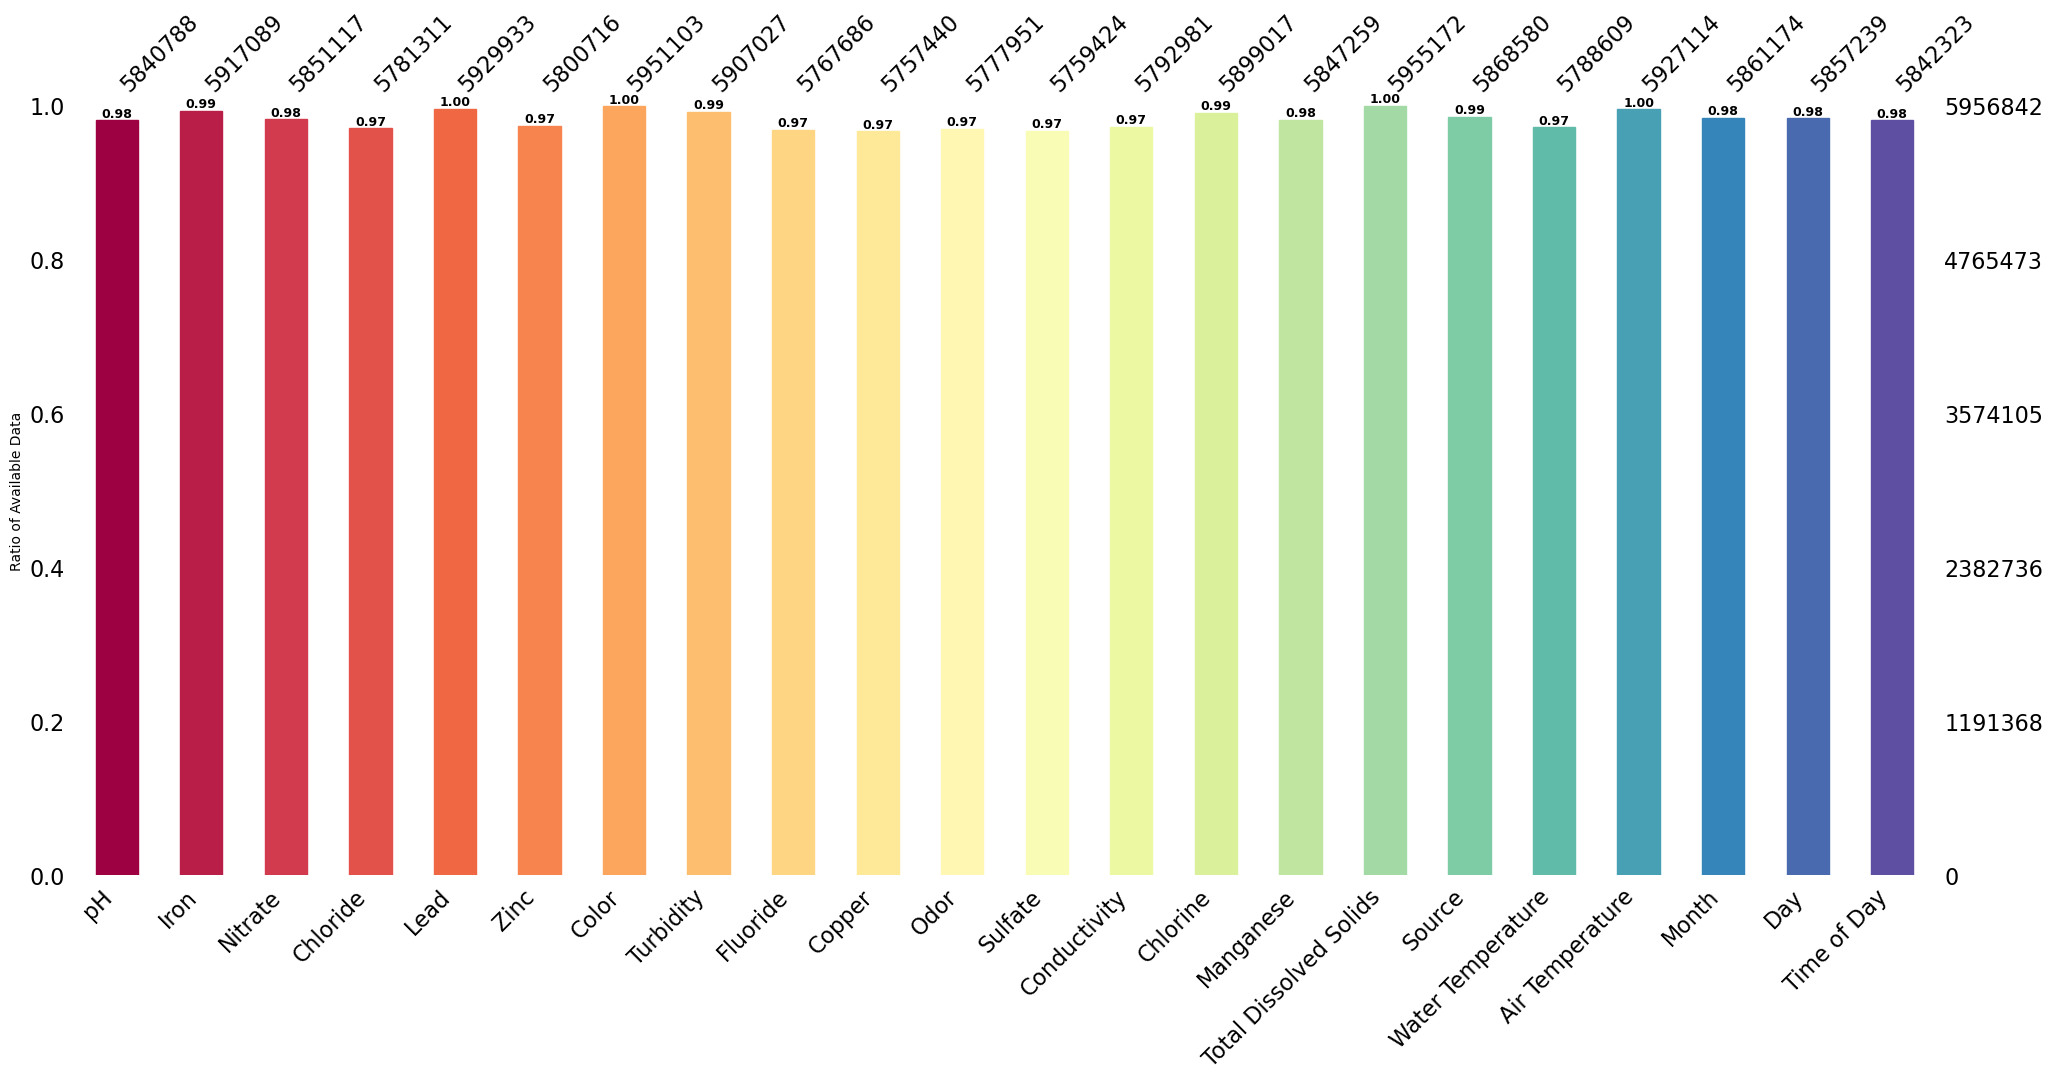

In [7]:
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np

# Your print statements
print('~' * 100)
print('Plot of data points excluding the missing values : ')
print('~' * 100)

# Dropping the specified columns
data_subset = data.drop(columns=['Index', 'Target'])

# Generating the missingno bar plot
ax = msno.bar(data_subset)

# Create a color palette with a unique color for each bar
colors = plt.cm.Spectral(np.linspace(0, 1, data_subset.shape[1]))

# Annotate the bars with the percentage of the total (the height of the bars)
for bar, color in zip(ax.patches, colors):
    # Get the height and the position
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    
    # The y position is adjusted to be just above the bar, or at the top of the plot area if the bar is too short
    y = height if height > 0.02 else 0.02  # Adjust 0.02 if necessary to fit within your plot dimensions
    
    # Annotate the bar with the height (as a percentage of the total)
    ax.text(x, y, f'{height:.2f}', ha='center', va='bottom', fontsize=9, color='black', weight='bold')
    
    # Set the bar color
    bar.set_color(color)

# Set the y-axis label to indicate the ratio
ax.set_ylabel('Ratio of Available Data')

# Show the plot
plt.show()

## Handling Missing values

In [8]:
# Handling Missing values
# Quantitative columns: Imputing with median
quantitative_columns = ['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Turbidity', 
                        'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity', 'Chlorine', 
                        'Manganese', 'Total Dissolved Solids', 'Water Temperature', 'Air Temperature']
for col in quantitative_columns:
    data[col].fillna(data[col].median(), inplace=True)

# Categorical columns: Imputing with mode
categorical_columns = ['Color', 'Source']
for col in categorical_columns:
    data[col].fillna(data[col].mode()[0], inplace=True)

# Temporal columns: Forward fill
temporal_columns = ['Month', 'Day', 'Time of Day']
for col in temporal_columns:
    data[col].fillna(method='ffill', inplace=True)


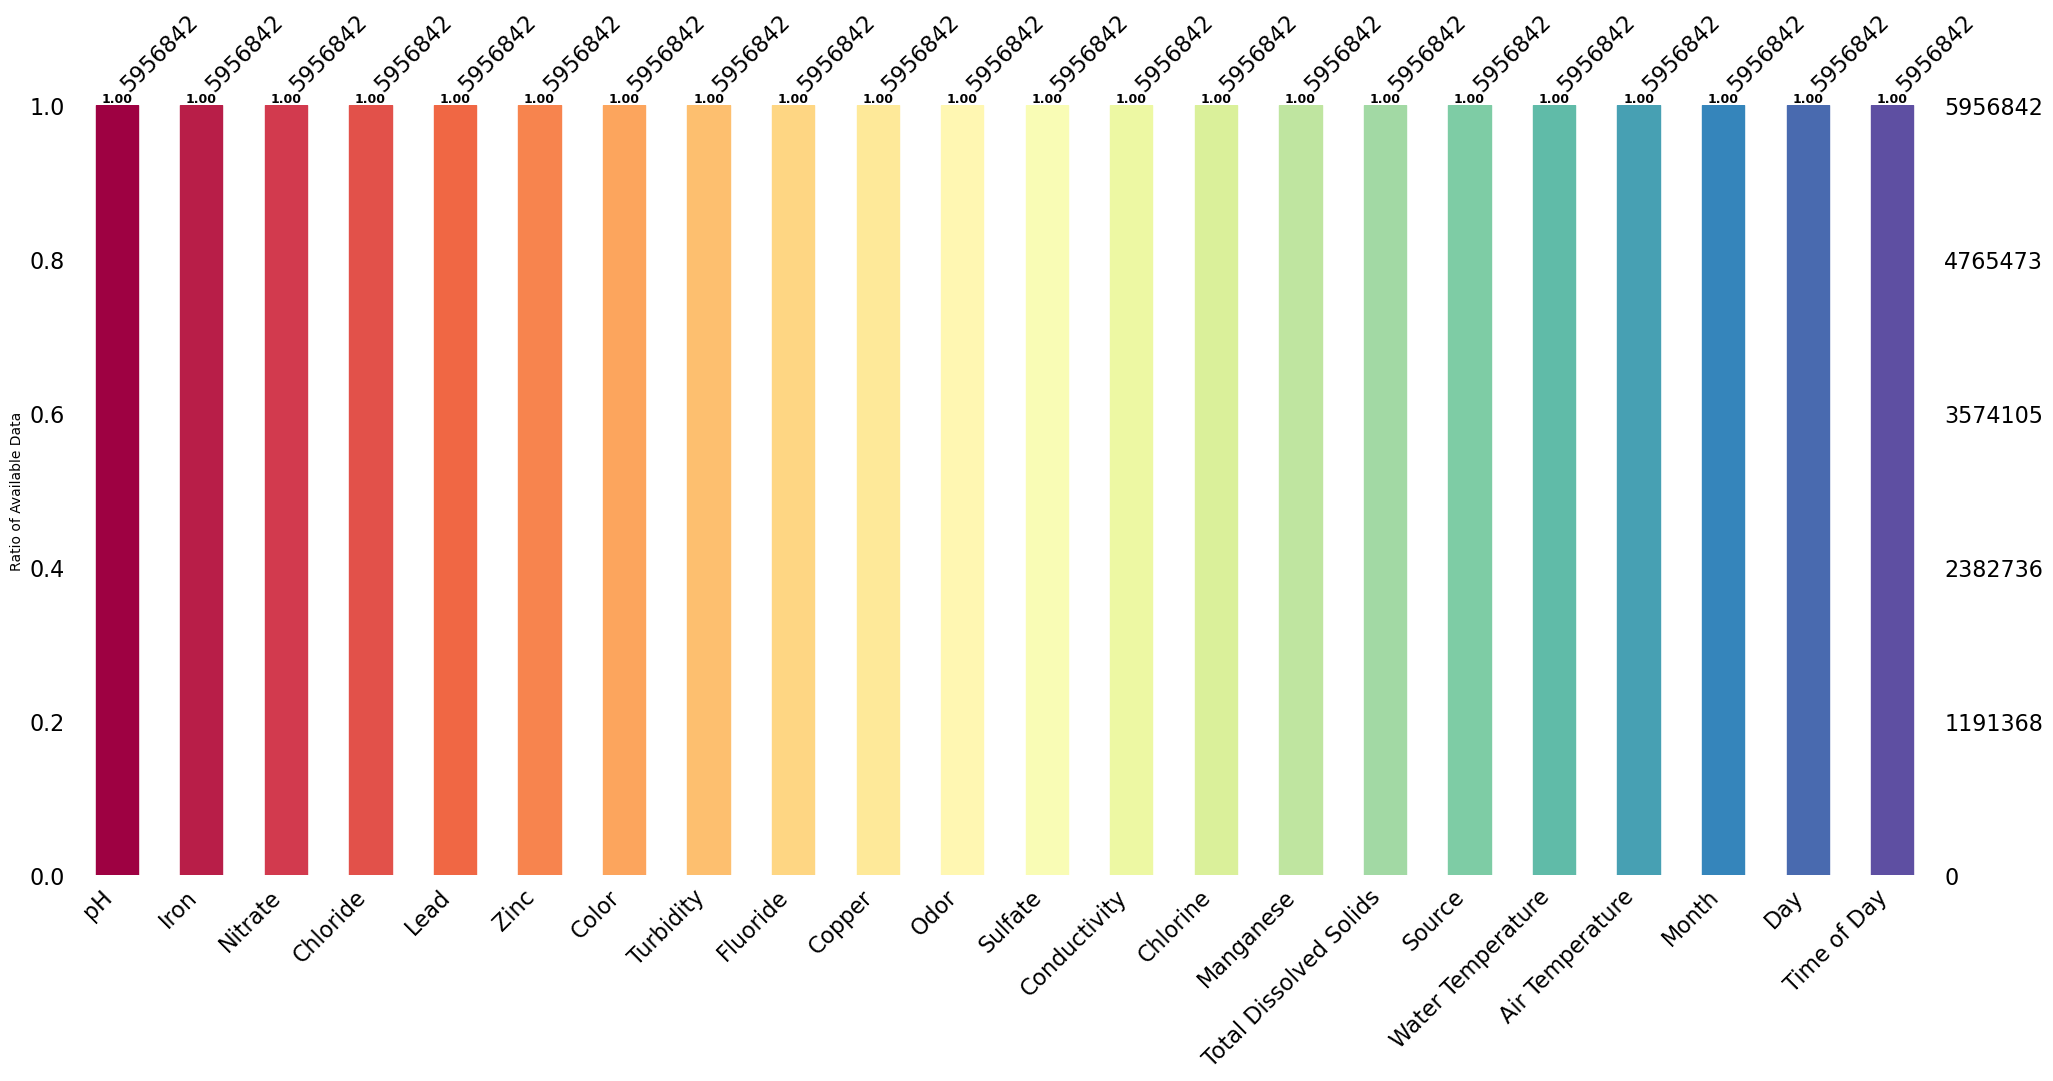

In [9]:
import missingno as msno
import matplotlib.pyplot as plt
import numpy as np
'''
# Your print statements
print('~' * 100)
print('Plot of data points excluding the missing values : ')
print('~' * 100)
'''

# Dropping the specified columns
# data_subset = data.drop(columns=['Index', 'Target'])

# Generating the missingno bar plot
ax = msno.bar(data.drop(columns=['Index', 'Target']))

# Create a color palette with a unique color for each bar
colors = plt.cm.Spectral(np.linspace(0, 1, data_subset.shape[1]))

# Annotate the bars with the percentage of the total (the height of the bars)
for bar, color in zip(ax.patches, colors):
    # Get the height and the position
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    
    # The y position is adjusted to be just above the bar, or at the top of the plot area if the bar is too short
    y = height if height > 0.02 else 0.02  # Adjust 0.02 if necessary to fit within your plot dimensions
    
    # Annotate the bar with the height (as a percentage of the total)
    ax.text(x, y, f'{height:.2f}', ha='center', va='bottom', fontsize=9, color='black', weight='bold')
    
    # Set the bar color
    bar.set_color(color)

# Set the y-axis label to indicate the ratio
ax.set_ylabel('Ratio of Available Data')

# Show the plot
plt.show()

In [10]:
## Checking missing values after handling
print("Missing Values:\n", round(data.isnull().sum()*100/data.shape[0],2))

Missing Values:
 Index                     0.0
pH                        0.0
Iron                      0.0
Nitrate                   0.0
Chloride                  0.0
Lead                      0.0
Zinc                      0.0
Color                     0.0
Turbidity                 0.0
Fluoride                  0.0
Copper                    0.0
Odor                      0.0
Sulfate                   0.0
Conductivity              0.0
Chlorine                  0.0
Manganese                 0.0
Total Dissolved Solids    0.0
Source                    0.0
Water Temperature         0.0
Air Temperature           0.0
Month                     0.0
Day                       0.0
Time of Day               0.0
Target                    0.0
dtype: float64


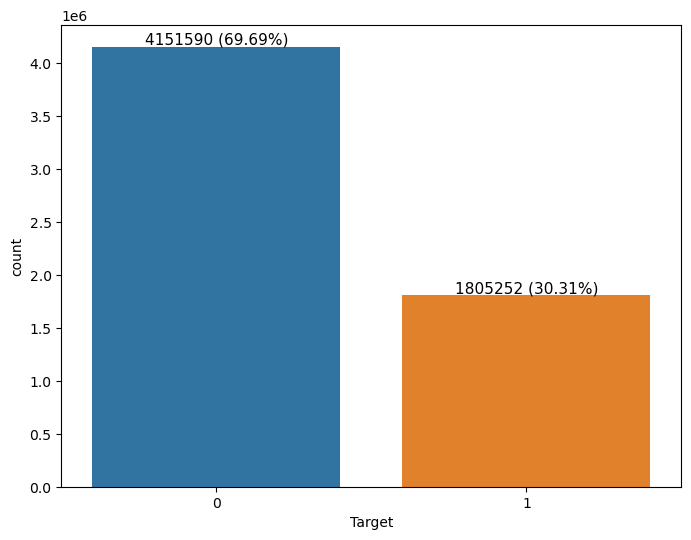

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.countplot(x='Target', data=data)
# Calculate the percentage of each category
total = float(len(data))
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{int(height)} ({height/total:.2%})', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')

plt.show()


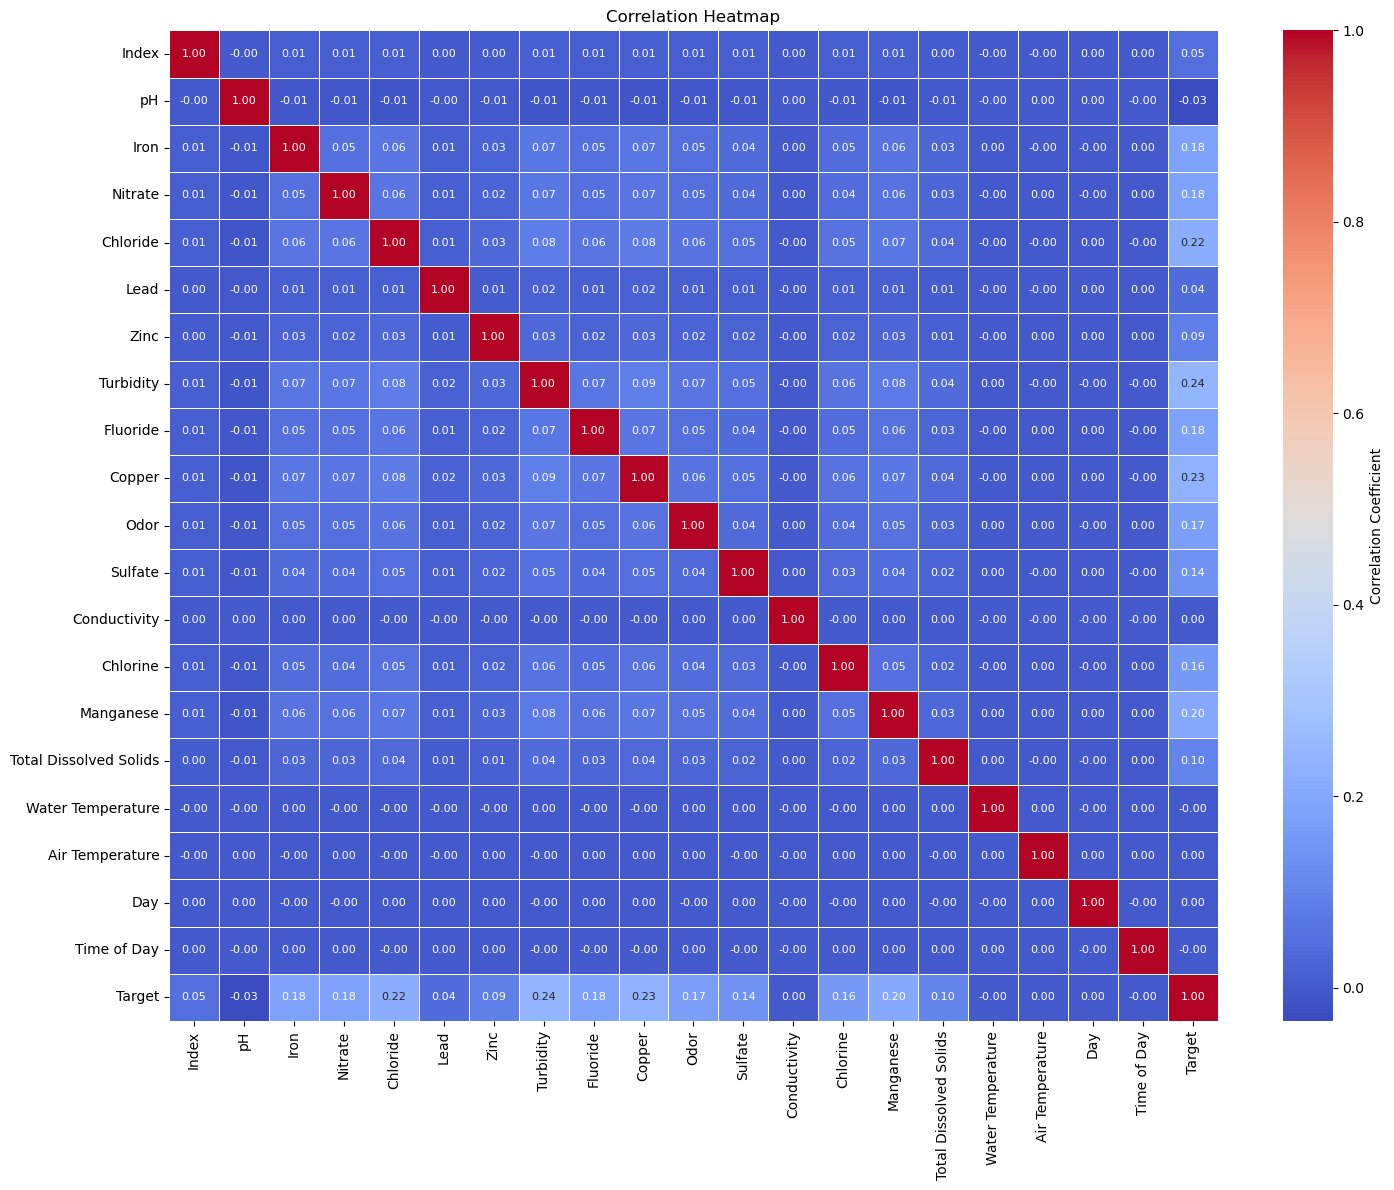

In [12]:
# Calculate the correlation matrix for numeric columns only
correlation_matrix = data.corr(numeric_only=True)

# Set the size of the figure
plt.figure(figsize=(15, 12))

# Generate the heatmap with annotations
sns.heatmap(
    correlation_matrix,
    annot=True,  # Annotate the cells with correlation values
    cmap="coolwarm",  # Choose the color map
    fmt=".2f",  # Format the annotations to 2 decimal places
    annot_kws={"size": 8},  # Reduce the font size of annotations
    linewidths=.5,  # Add lines between cells for clarity
    cbar_kws={'label': 'Correlation Coefficient'}  # Add label to the colorbar
)

# Rotate y-axis labels for better readability
plt.yticks(rotation=0)  

# Set the title for the heatmap
plt.title("Correlation Heatmap")

# Ensure tight layout for better aesthetics
plt.tight_layout()

# Show the heatmap
plt.show()


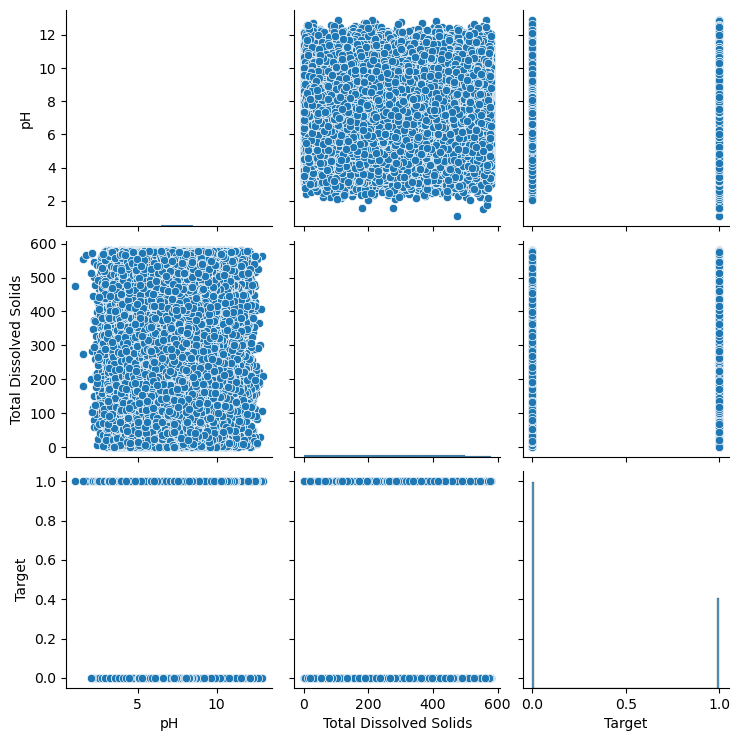

In [13]:
# Pairplot for numerical features
selected_cols = ['pH','Total Dissolved Solids','Target']  # Replace with your chosen columns
sns.pairplot(data=data[selected_cols])
plt.show()

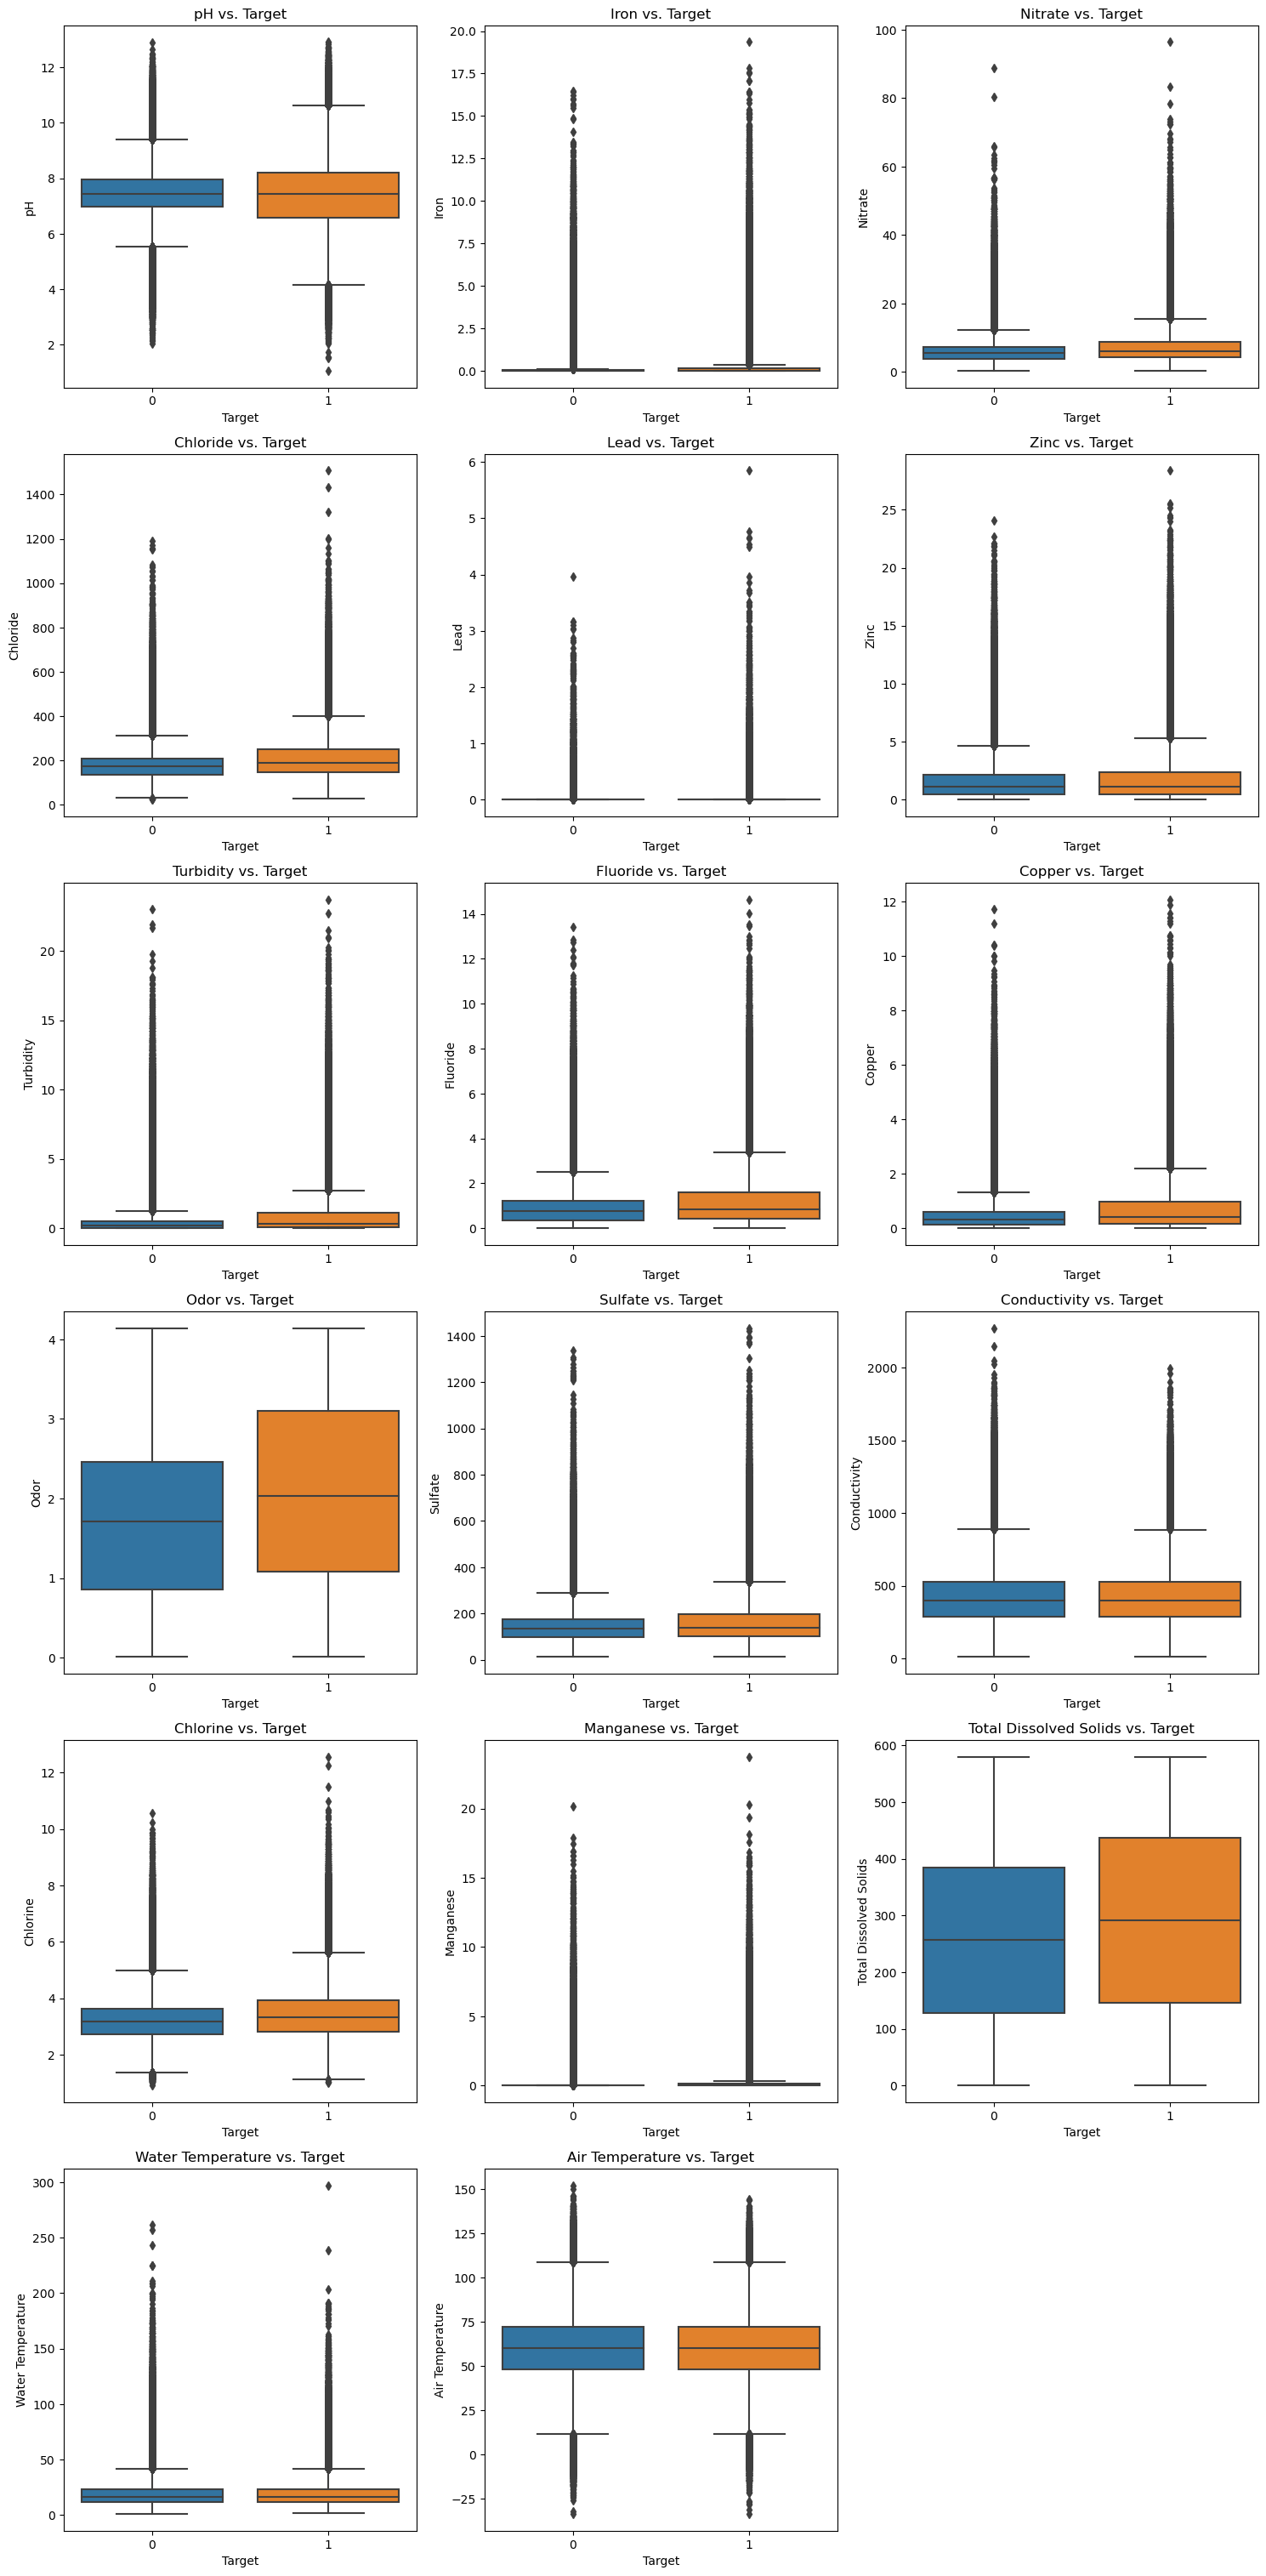

In [14]:
numerical_cols = quantitative_columns

# Number of columns and rows for the grid
num_columns = 3
num_rows = int(len(numerical_cols) / num_columns) + (len(numerical_cols) % num_columns)

# Setting up the grid
fig = plt.figure(figsize=(15, 5 * num_rows))
gs = gridspec.GridSpec(num_rows, num_columns, figure=fig)

for idx, feature in enumerate(numerical_cols):
    ax = fig.add_subplot(gs[idx])
    sns.boxplot(data=data, x="Target", y=feature, ax=ax)
    ax.set_title(f"{feature} vs. Target")

plt.tight_layout()
plt.show()


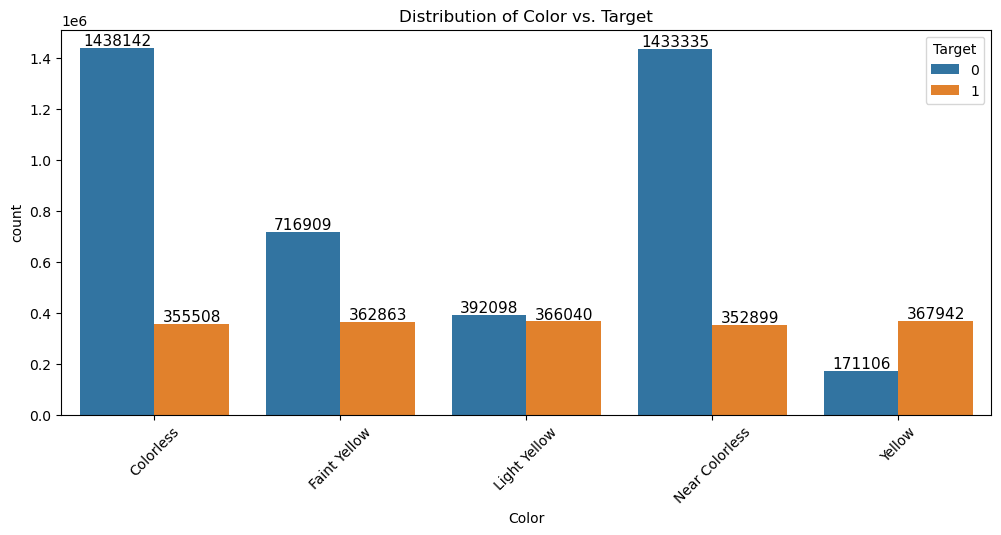

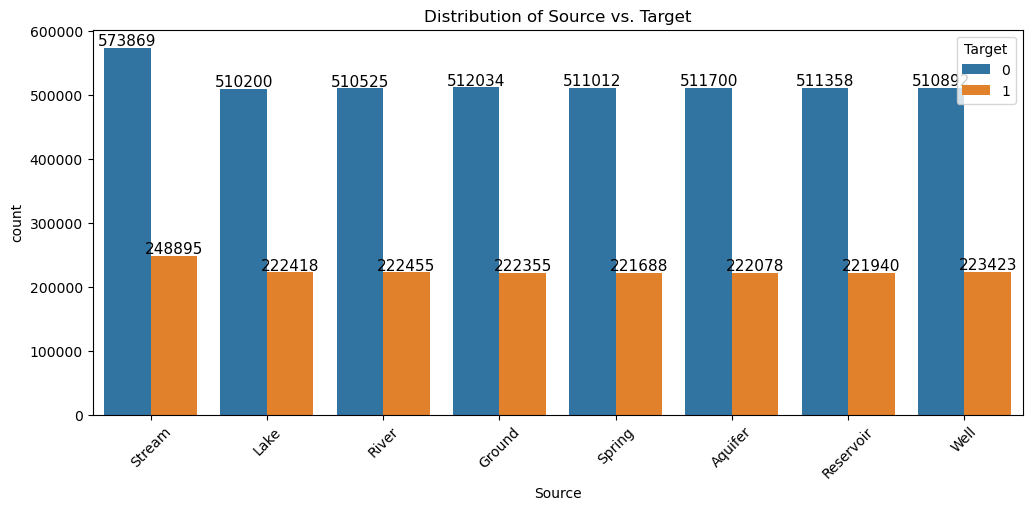

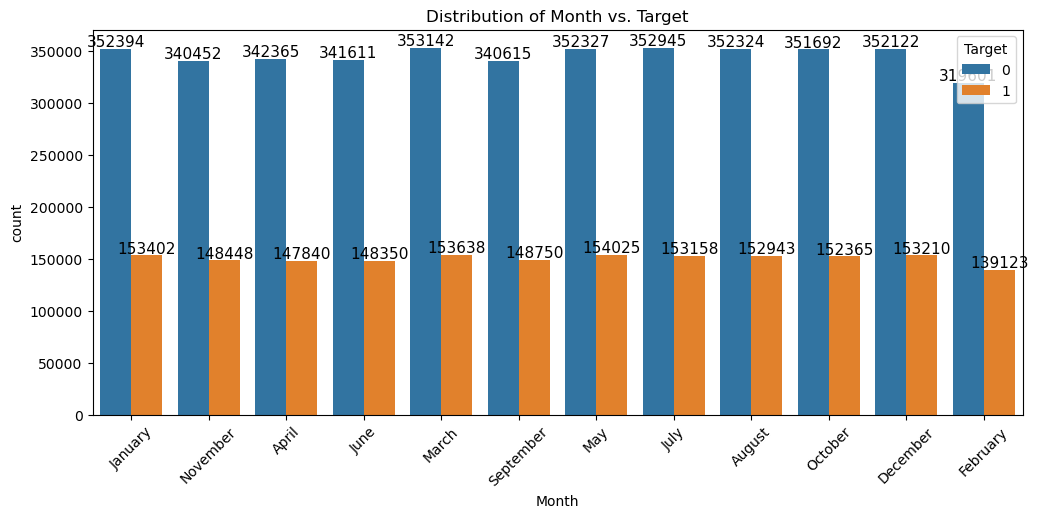

In [15]:
# Get the list of categorical columns
categorical_cols = data.select_dtypes(include=[np.object]).columns.tolist()

# Loop through each categorical feature
for feature in categorical_cols:
    # Create a new figure
    plt.figure(figsize=(12, 5))
    
    # Create a count plot
    ax = sns.countplot(data=data, x=feature, hue="Target")
    
    # Set the title
    plt.title(f"Distribution of {feature} vs. Target")
    
    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45)
    
    # Add count labels on top of the bars
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
    # Show the plot
    plt.show()

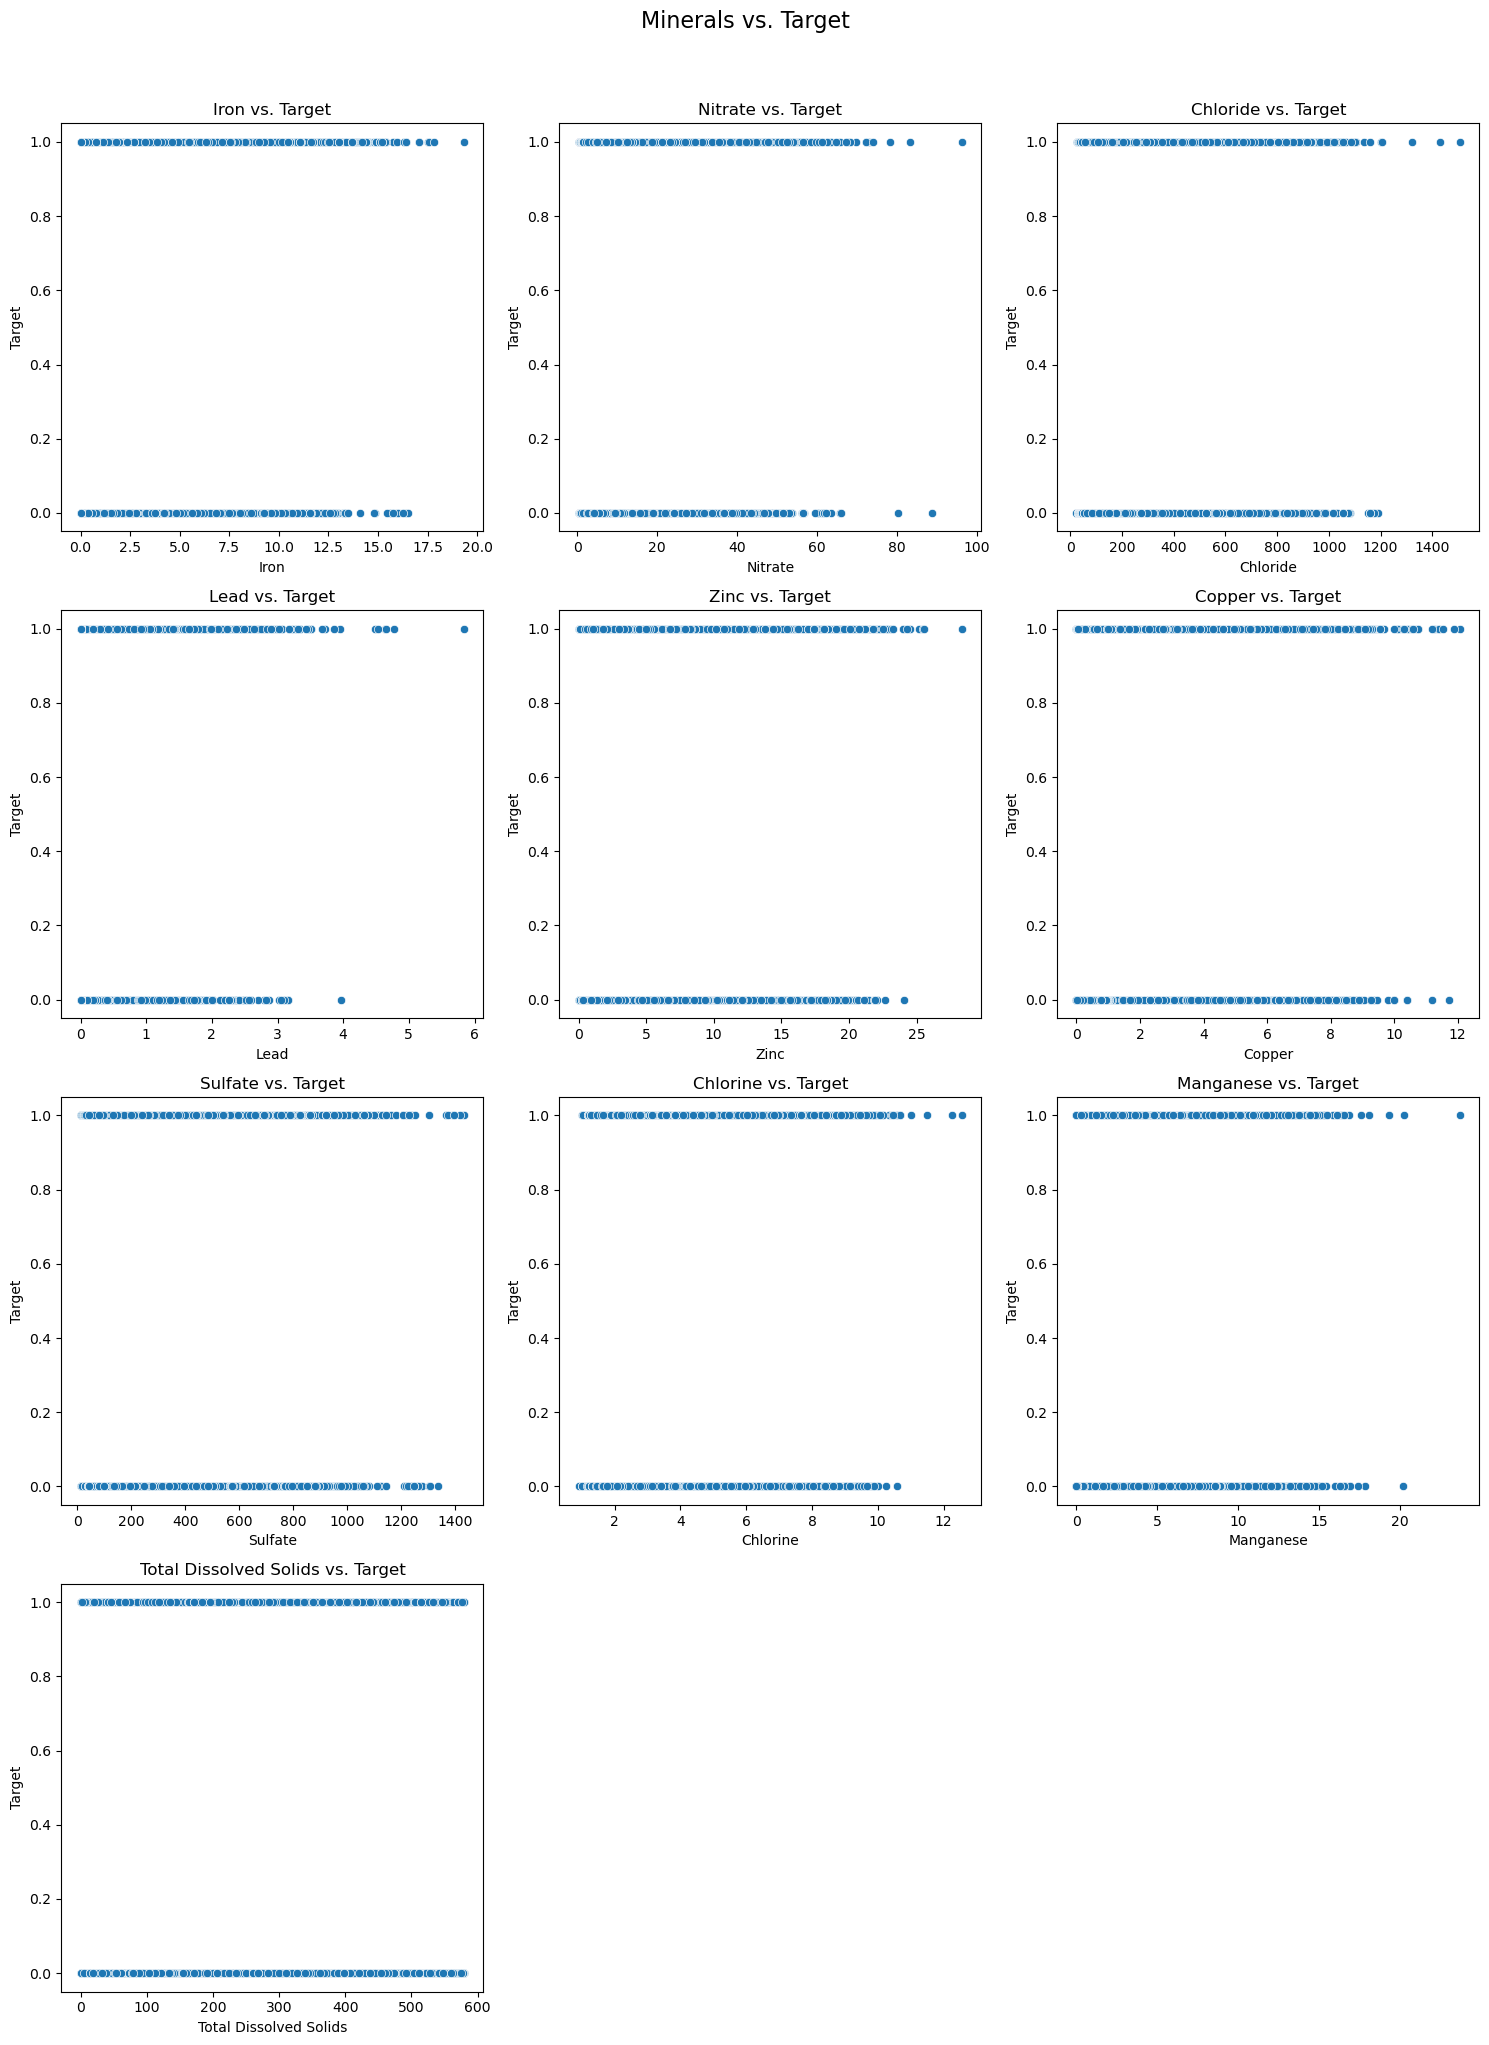

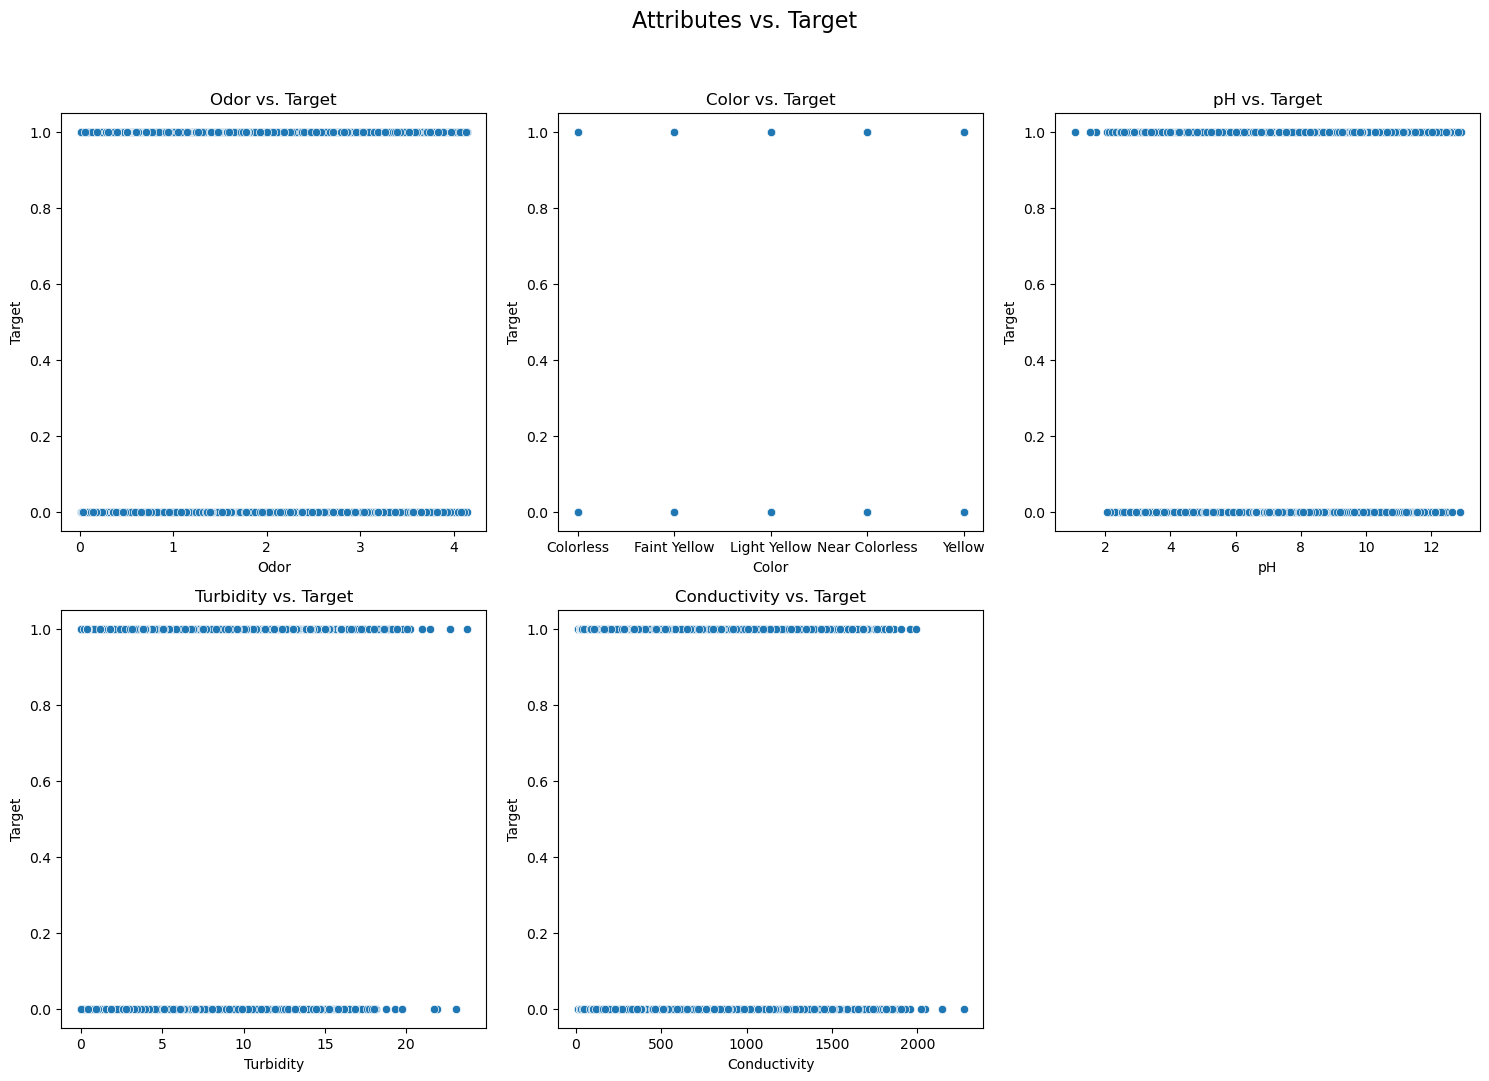

In [16]:
# List of minerals and attributes
minerals = ['Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Copper', 'Sulfate', 'Chlorine', 'Manganese', 'Total Dissolved Solids']
attributes = ['Odor', 'Color', 'pH', 'Turbidity', 'Conductivity']

# Helper function to create a grid of scatter plots
def create_scatter_grid(features, target, grid_title):
    num_columns = 3
    num_rows = int(len(features) / num_columns) + (len(features) % num_columns)
    
    fig = plt.figure(figsize=(15, 5 * num_rows))
    gs = gridspec.GridSpec(num_rows, num_columns, figure=fig)
    
    for idx, feature in enumerate(features):
        ax = fig.add_subplot(gs[idx])
        sns.scatterplot(data=data, x=feature, y=target, ax=ax)
        ax.set_title(f"{feature} vs. {target}")
    
    plt.suptitle(grid_title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

# Grid 1: Minerals vs. Target
create_scatter_grid(minerals, 'Target', 'Minerals vs. Target')

# Grid 2: Attributes vs. Target
create_scatter_grid(attributes, 'Target', 'Attributes vs. Target')


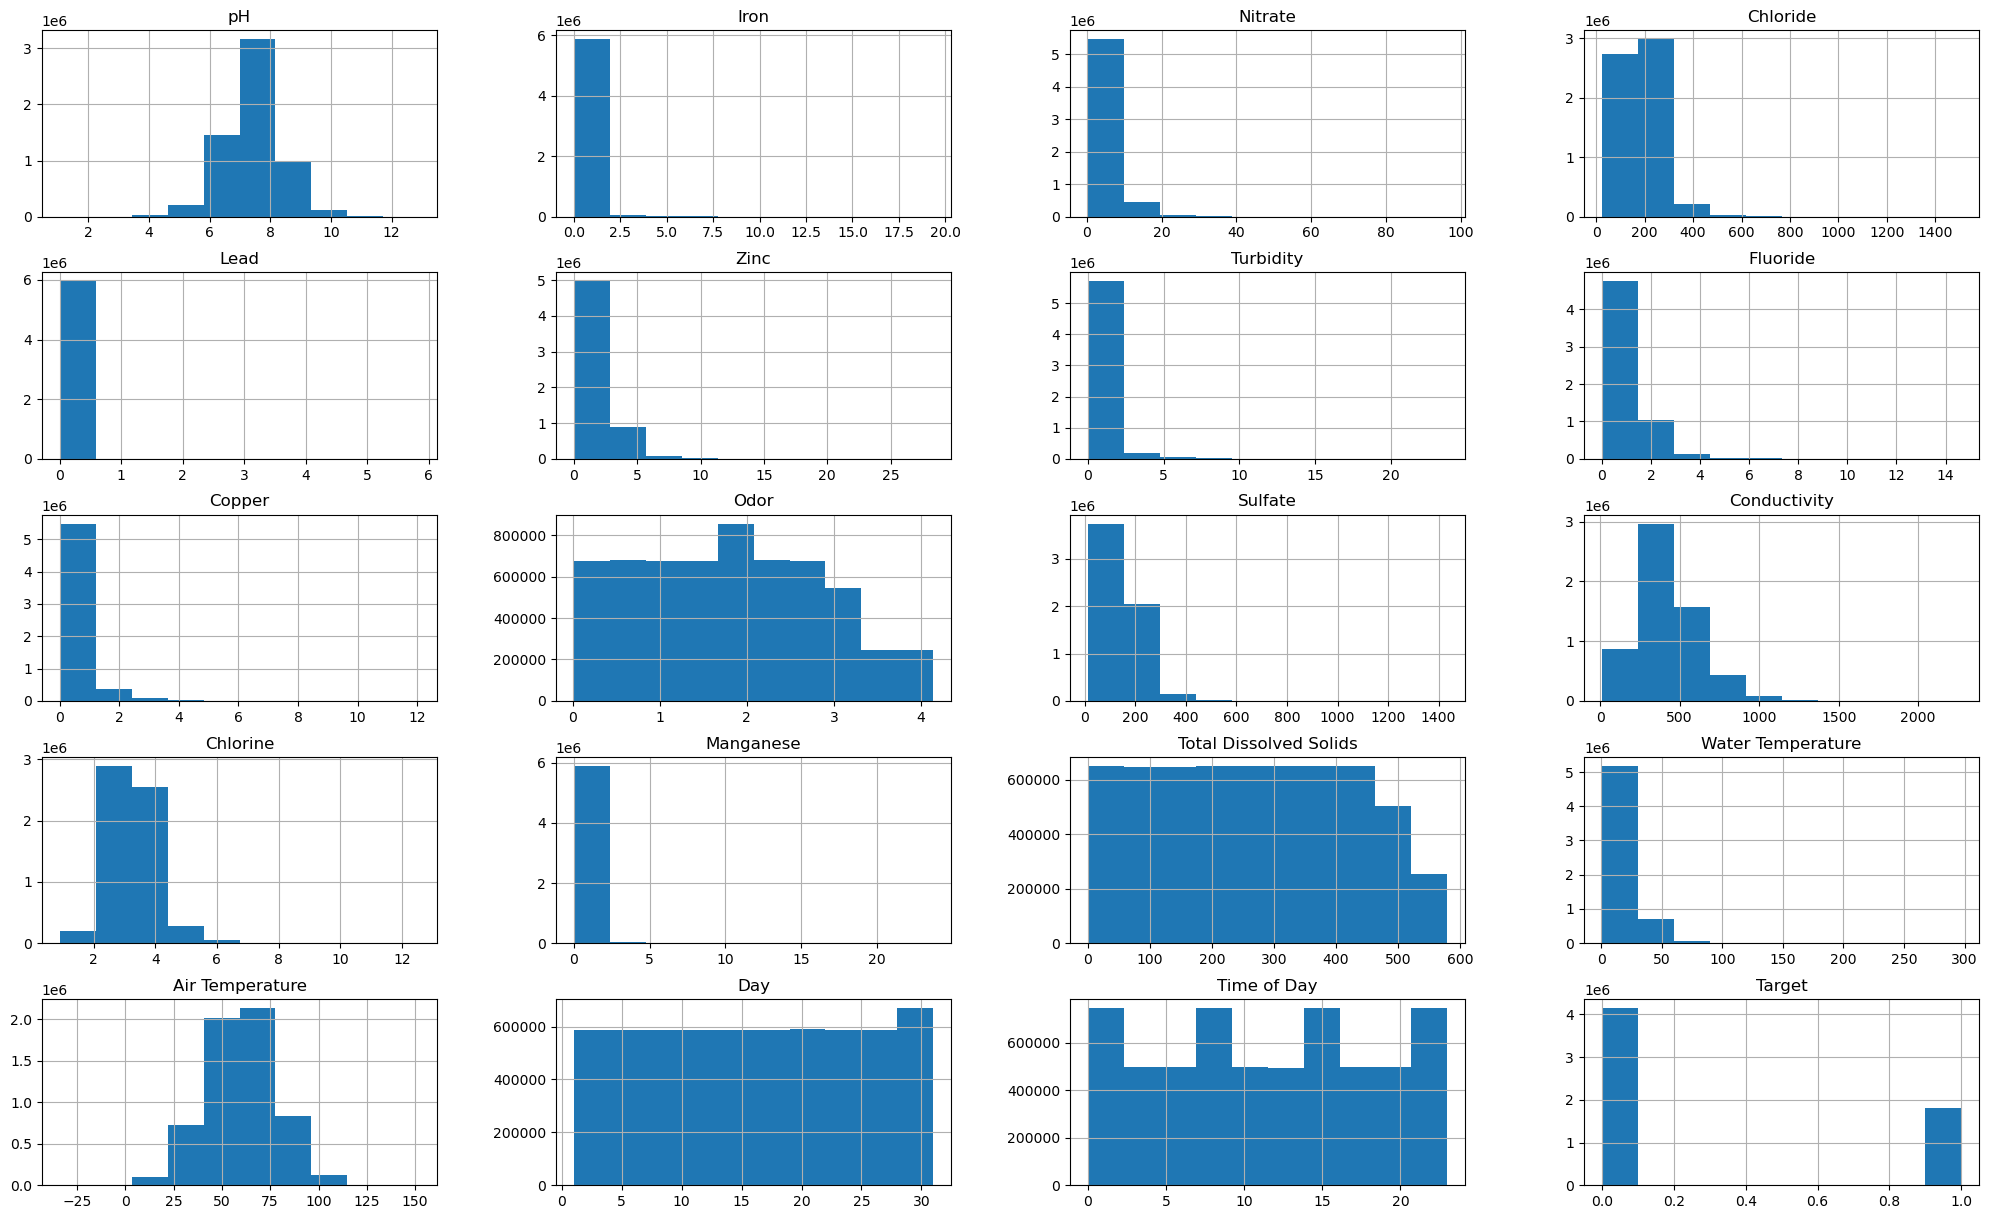

In [17]:
plt.rcParams['figure.figsize'] = [25,15]
data.drop('Index', axis=1).hist()
plt.show()

In [18]:
# This will display the number of unique values for each column in your data DataFrame.
data.nunique()

Index                     5956842
pH                        5604785
Iron                      5674876
Nitrate                   5614445
Chloride                  5549789
Lead                      5542383
Zinc                      5567923
Color                           5
Turbidity                 5665514
Fluoride                  5537537
Copper                    5528121
Odor                      5547049
Sulfate                   5529950
Conductivity              5560632
Chlorine                  5658153
Manganese                 5610685
Total Dissolved Solids    5709788
Source                          8
Water Temperature         5556716
Air Temperature           5684020
Month                          12
Day                            31
Time of Day                    24
Target                          2
dtype: int64

In [19]:
data_combined = pd.concat([data.head(), data.tail()])
data_combined

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Color,Turbidity,Fluoride,...,Chlorine,Manganese,Total Dissolved Solids,Source,Water Temperature,Air Temperature,Month,Day,Time of Day,Target
0,0,8.332988,0.000083,8.605777,122.799772,3.713298e-52,3.434827,Colorless,0.022683,0.607283,...,3.708178,2.269945e-15,332.118789,Stream,16.444276,43.493324,January,29.0,4.0,0
1,1,6.917863,0.000081,3.734167,227.029851,7.849262e-94,1.245317,Faint Yellow,0.019007,0.622874,...,3.292038,8.024076e-07,284.641984,Lake,15.348981,71.220586,November,26.0,16.0,0
2,2,5.443762,0.020106,3.816994,230.995630,5.286616e-76,0.528280,Light Yellow,0.319956,0.423423,...,3.560224,7.007989e-02,570.054094,River,11.643467,44.891330,January,31.0,8.0,0
3,3,7.955339,0.143988,8.224944,178.129940,3.997118e-176,4.027879,Near Colorless,0.166319,0.208454,...,3.516907,2.468295e-02,100.043838,Ground,10.092392,60.843233,April,1.0,21.0,0
4,4,8.091909,0.002167,9.925788,186.540872,4.171069e-132,3.807511,Light Yellow,0.004867,0.222912,...,3.177849,3.296139e-03,168.075545,Spring,15.249416,69.336671,June,29.0,7.0,0
5956837,5956837,8.418457,0.000095,8.427576,256.570863,4.751543e-26,4.967504,Faint Yellow,3.824532,0.541850,...,2.630130,9.608234e-03,545.990529,Well,21.436974,70.493951,February,8.0,8.0,1
5956838,5956838,7.950573,0.215729,4.677850,292.727780,4.679421e-12,1.842063,Near Colorless,1.181166,2.747241,...,3.555576,1.875424e-11,514.136530,Ground,19.064632,67.052475,September,8.0,6.0,1
5956839,5956839,8.145572,0.000005,7.112877,254.831175,3.150254e-56,0.656923,Colorless,1.769609,1.398686,...,3.127251,1.199405e+00,336.947289,Stream,5.863636,64.086020,January,16.0,11.0,1
5956840,5956840,8.273548,0.001236,10.182408,122.842038,4.226073e-33,0.903032,Light Yellow,0.366909,3.076229,...,2.762962,2.824411e+00,112.458644,Stream,28.034083,18.158372,March,29.0,13.0,1
5956841,5956841,7.539523,0.022760,4.902591,106.256430,1.399449e-10,1.069694,Light Yellow,0.371766,0.995846,...,6.033203,2.838596e-01,118.556879,Aquifer,6.594036,51.751181,June,9.0,2.0,1


In [20]:
month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

data['Months'] = data['Month'].map(month_mapping)
data=data.drop(['Month'],axis=1)
data.Months.value_counts()

3     506780
5     506352
7     506103
1     505796
12    505332
8     505267
10    504057
4     490205
6     489961
9     489365
11    488900
2     458724
Name: Months, dtype: int64

The code you provided will encode the categorical columns 'Source' and 'Color' in the data DataFrame using one-hot encoding. The resulting DataFrame will be stored in the data_encoded variable.

The parameter drop_first=True ensures that one column is dropped (to avoid multicollinearity) from the one-hot encoded columns for each category. This is useful especially for linear models which are sensitive to multicollinearity.

After executing this code, data_encoded will have new columns for each unique value in 'Source' and 'Color' (minus one column for each due to the drop_first parameter), and the original 'Source' and 'Color' columns will be removed.

In [21]:
# Encoding categorical columns(Source and Color) using One-hot encoding
data_encoded = pd.get_dummies(data, columns=['Source', 'Color'], drop_first=True)

In [22]:
# Select only the numerical columns for outlier detection
numerical_columns = data_encoded.select_dtypes(include=['float64', 'int64'])

# Calculate quartiles and IQR for numerical columns
Q1 = numerical_columns.quantile(0.25)
Q3 = numerical_columns.quantile(0.75)
IQR = Q3 - Q1

# Getting boolean dataframe where True indicates the presence of an outlier
outliers = ((numerical_columns < (Q1 - 1.5 * IQR)) | (numerical_columns > (Q3 + 1.5 * IQR))).sum()
#print((outliers * 100) / data.shape[0])

# Identify the top 20 features with the highest number of outliers
top_20_outlier_features = outliers.sort_values(ascending=False).head(20).index
top_20_outlier_features

Index(['Lead', 'Manganese', 'Iron', 'Turbidity', 'Copper', 'Water Temperature',
       'Fluoride', 'Zinc', 'Chloride', 'Nitrate', 'pH', 'Sulfate',
       'Conductivity', 'Chlorine', 'Air Temperature', 'Target', 'Time of Day',
       'Day', 'Index', 'Total Dissolved Solids'],
      dtype='object')

In [23]:
# Initialize an empty list to store the results
outlier_percentage = []

# Calculate the quartiles and detect outliers for each column
for col in data_encoded.columns:
    # Calculate the first quartile (Q1)
    Q1 = stats.scoreatpercentile(data_encoded[col], 25)
    
    # Calculate the third quartile (Q3)
    Q3 = stats.scoreatpercentile(data_encoded[col], 75)
    
    # Calculate the Interquartile Range (IQR)
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Count the number of outliers in the column
    num_outliers = ((data_encoded[col] < lower_bound) | (data_encoded[col] > upper_bound)).sum()
    
    # Calculate the percentage of outliers
    percentage = (num_outliers / len(data_encoded)) * 100
    
    # Append the result as a dictionary to the list
    outlier_percentage.append({"Column": col, "Percentage of Outliers": percentage})

# Convert the list of results to a DataFrame
outlier_percentage_df = pd.DataFrame(outlier_percentage)

# Display the percentage of outliers for each column
# print(outlier_percentage_df)

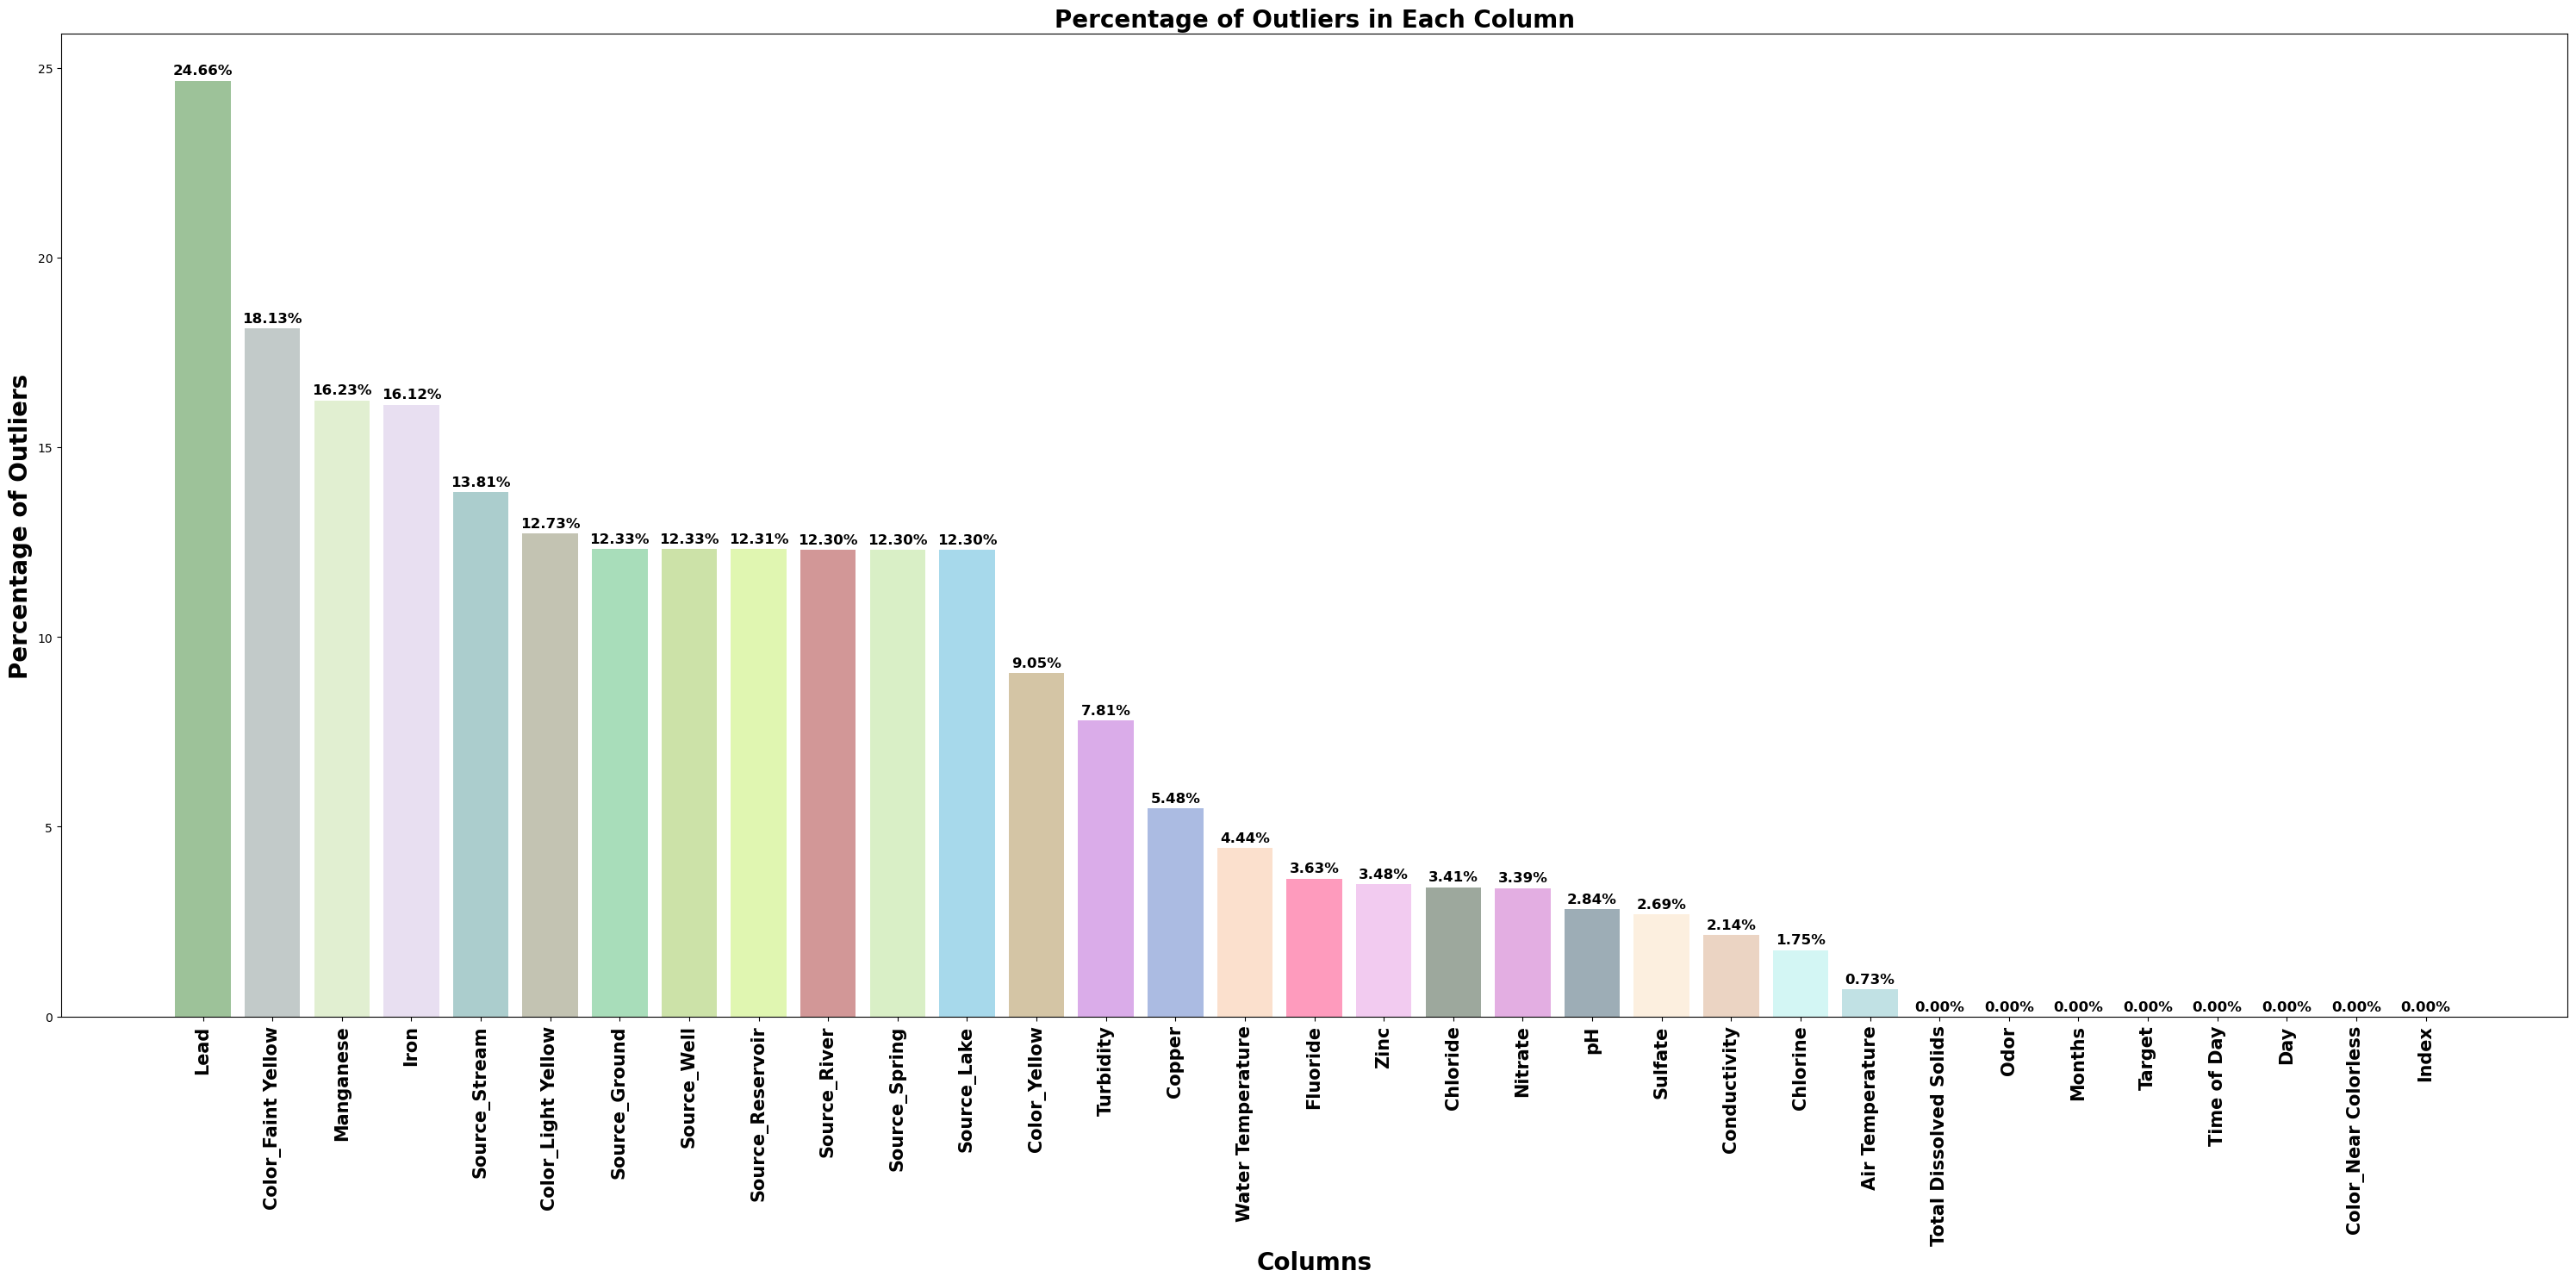

In [24]:
# Function to generate random pastel colors
import random
def random_pastel_color():
    return f'#{random.randint(150, 255):02X}{random.randint(150, 255):02X}{random.randint(150, 255):02X}'

# Sort the DataFrame by Percentage of Outliers in descending order for better visualization
outlier_percentage_df_sorted = outlier_percentage_df.sort_values(by='Percentage of Outliers', ascending=False)

# Generate random pastel colors for the bars
random_colors = [random_pastel_color() for _ in range(len(outlier_percentage_df_sorted))]

# Create a bar chart with random pastel colors
plt.figure(figsize=(30, 15))  # Adjusted figure size
bars = plt.bar(outlier_percentage_df_sorted['Column'], outlier_percentage_df_sorted['Percentage of Outliers'], color=random_colors)

# Add labels and title
plt.xlabel('Columns', fontsize=20, fontweight='bold')
plt.ylabel('Percentage of Outliers', fontsize=20, fontweight='bold')
plt.title('Percentage of Outliers in Each Column', fontsize=20, fontweight='bold')

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Add values on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}%', 
                 xy=(bar.get_x() + bar.get_width() / 2, height), 
                 xytext=(0, 3),  # 3 points vertical offset
                 textcoords="offset points",
                 ha='center', 
                 va='bottom',
                fontsize=12,
                weight='bold')
    
# Make column names on x-axis bold
plt.xticks(size=15, fontweight='bold')
# Show the plot
plt.tight_layout()
plt.show()


In [25]:
for col in data_encoded.columns:
    try:
        # Remove NaN values before calculating IQR
        col_data = data_encoded[col].dropna()
        
        # Check if the column contains boolean values
        if col_data.dtype == bool:
            # Skip boolean columns, you may want to handle them differently if needed
            print(f"Skipping boolean column '{col}'")
            continue
        
        # Calculate IQR for the cleaned data
        Q1 = col_data.quantile(0.25)
        Q3 = col_data.quantile(0.75)
        IQR = Q3 - Q1
        
        # Calculate upper and lower limits
        upper_limit = Q3 + 1.5 * IQR
        lower_limit = Q1 - 1.5 * IQR
        
        # Applying capping for outliers
        mask_upper = data_encoded[col] > upper_limit
        mask_lower = data_encoded[col] < lower_limit
        
        # Use bitwise OR operator to combine masks
        mask_outliers = mask_upper | mask_lower
        
        # Apply capping using masks
        data_encoded.loc[mask_upper, col] = upper_limit
        data_encoded.loc[mask_lower, col] = lower_limit
    except TypeError as e:
        print(f"Error in column '{col}': {e}")


In [26]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5956842 entries, 0 to 5956841
Data columns (total 33 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   Index                   float64
 1   pH                      float64
 2   Iron                    float64
 3   Nitrate                 float64
 4   Chloride                float64
 5   Lead                    float64
 6   Zinc                    float64
 7   Turbidity               float64
 8   Fluoride                float64
 9   Copper                  float64
 10  Odor                    float64
 11  Sulfate                 float64
 12  Conductivity            float64
 13  Chlorine                float64
 14  Manganese               float64
 15  Total Dissolved Solids  float64
 16  Water Temperature       float64
 17  Air Temperature         float64
 18  Day                     float64
 19  Time of Day             float64
 20  Target                  float64
 21  Months                  int64  

In [27]:
#  Shows first 5 rows of the data_encoded dataset, with outliers capped (if they existed in those rows).
data_encoded.head()

,Index,pH,Iron,Nitrate,Chloride,Lead,Zinc,Turbidity,Fluoride,Copper,...,Source_Lake,Source_Reservoir,Source_River,Source_Spring,Source_Stream,Source_Well,Color_Faint Yellow,Color_Light Yellow,Color_Near Colorless,Color_Yellow
0,0.0,8.332988,0.000083,8.605777,122.799772,3.713298e-52,3.434827,0.022683,0.607283,0.144599,...,0,0,0,0,0,0,0,0,0.0,0
1,1.0,6.917863,0.000081,3.734167,227.029851,7.849262e-94,1.245317,0.019007,0.622874,0.437835,...,0,0,0,0,0,0,0,0,0.0,0
2,2.0,5.443762,0.020106,3.816994,230.995630,5.286616e-76,0.528280,0.319956,0.423423,0.431588,...,0,0,0,0,0,0,0,0,0.0,0
3,3.0,7.955339,0.133920,8.224944,178.129940,3.997118e-176,4.027879,0.166319,0.208454,0.239451,...,0,0,0,0,0,0,0,0,1.0,0
4,4.0,8.091909,0.002167,9.925788,186.540872,4.171069e-132,3.807511,0.004867,0.222912,0.616574,...,0,0,0,0,0,0,0,0,0.0,0


In [28]:
data_encoded = data_encoded.drop(['Index','Day', 'Time of Day','Months'],axis=1)
print(data_encoded.columns)

Index(['pH', 'Iron', 'Nitrate', 'Chloride', 'Lead', 'Zinc', 'Turbidity',
       'Fluoride', 'Copper', 'Odor', 'Sulfate', 'Conductivity', 'Chlorine',
       'Manganese', 'Total Dissolved Solids', 'Water Temperature',
       'Air Temperature', 'Target', 'Source_Ground', 'Source_Lake',
       'Source_Reservoir', 'Source_River', 'Source_Spring', 'Source_Stream',
       'Source_Well', 'Color_Faint Yellow', 'Color_Light Yellow',
       'Color_Near Colorless', 'Color_Yellow'],
      dtype='object')


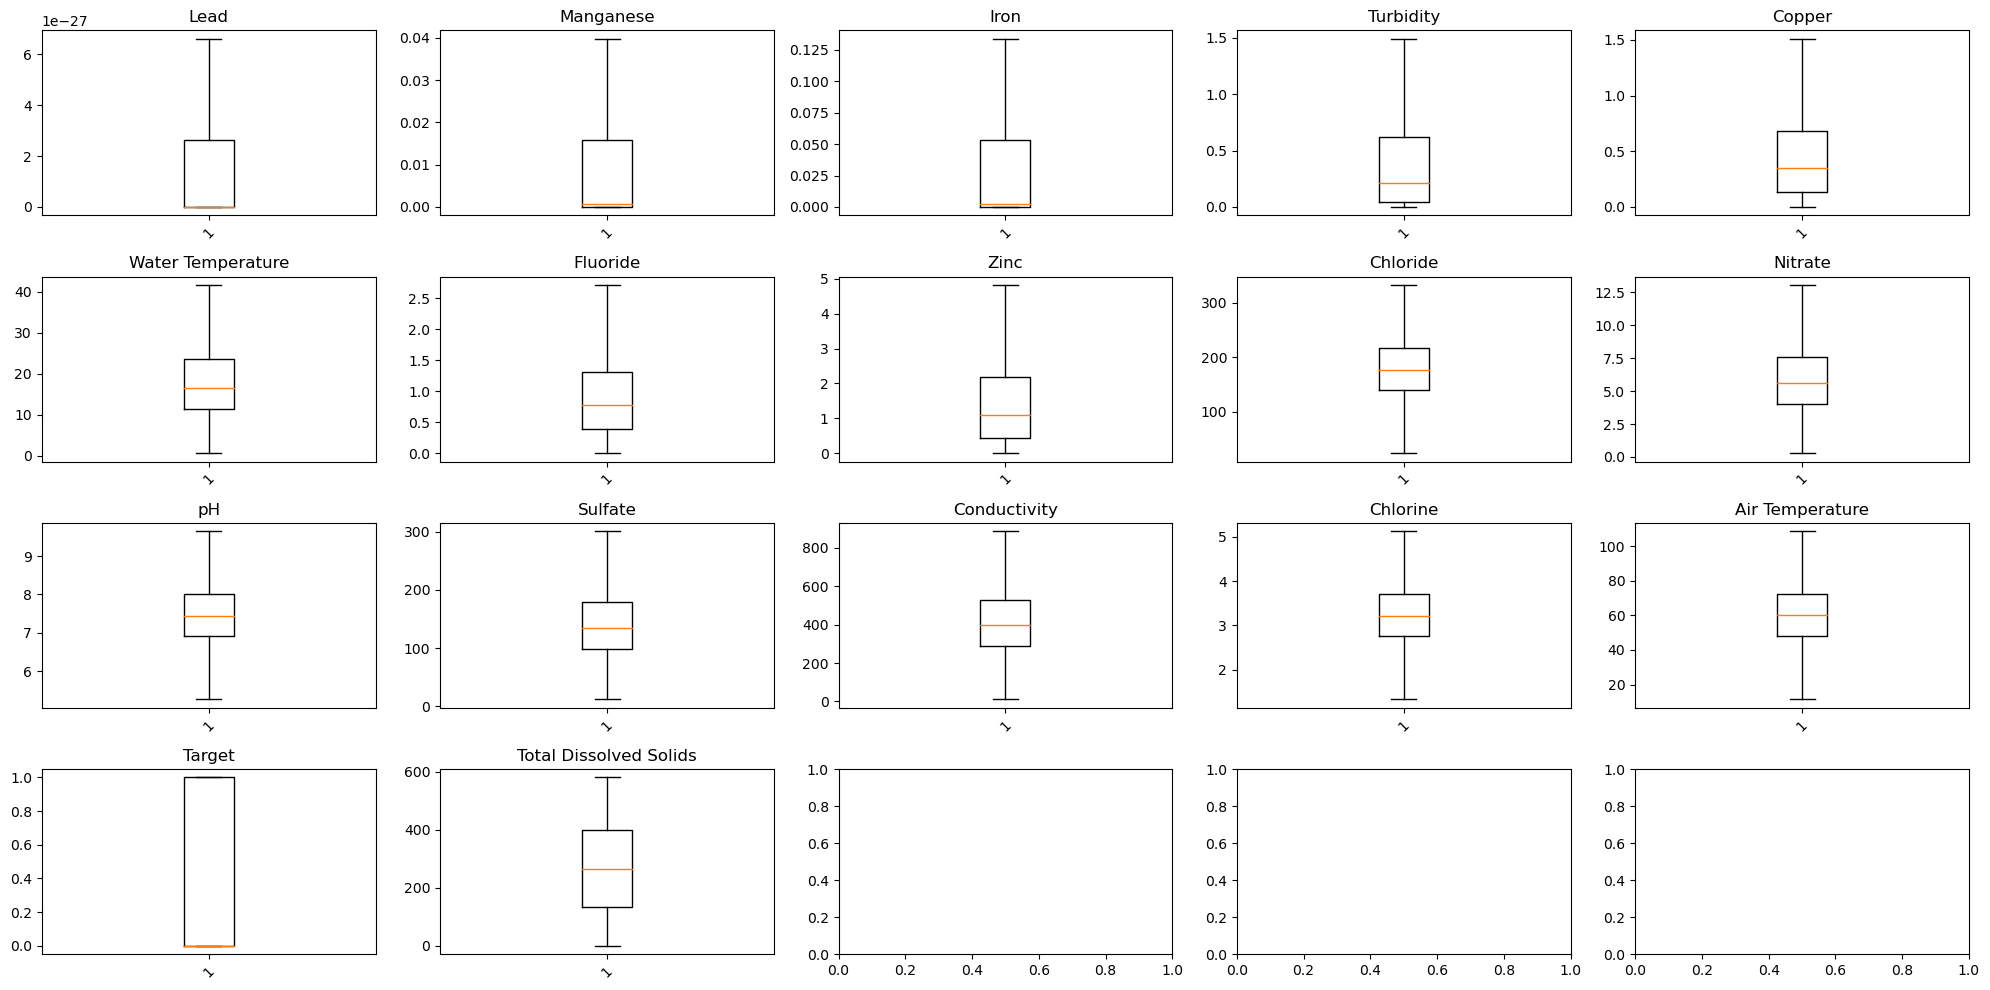

In [29]:
# Filter features that are present in data_encoded
filtered_features = [feature for feature in top_20_outlier_features if feature in data_encoded.columns]

# Set up the grid
fig, axs = plt.subplots(4, 5, figsize=(20,10))  # 4 rows and 5 columns to fit the top 20 features
axs = axs.ravel()  # Flatten axes array

for i, feature in enumerate(filtered_features):
    axs[i].boxplot(data_encoded[feature])
    axs[i].set_title(f'{feature}')
    axs[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

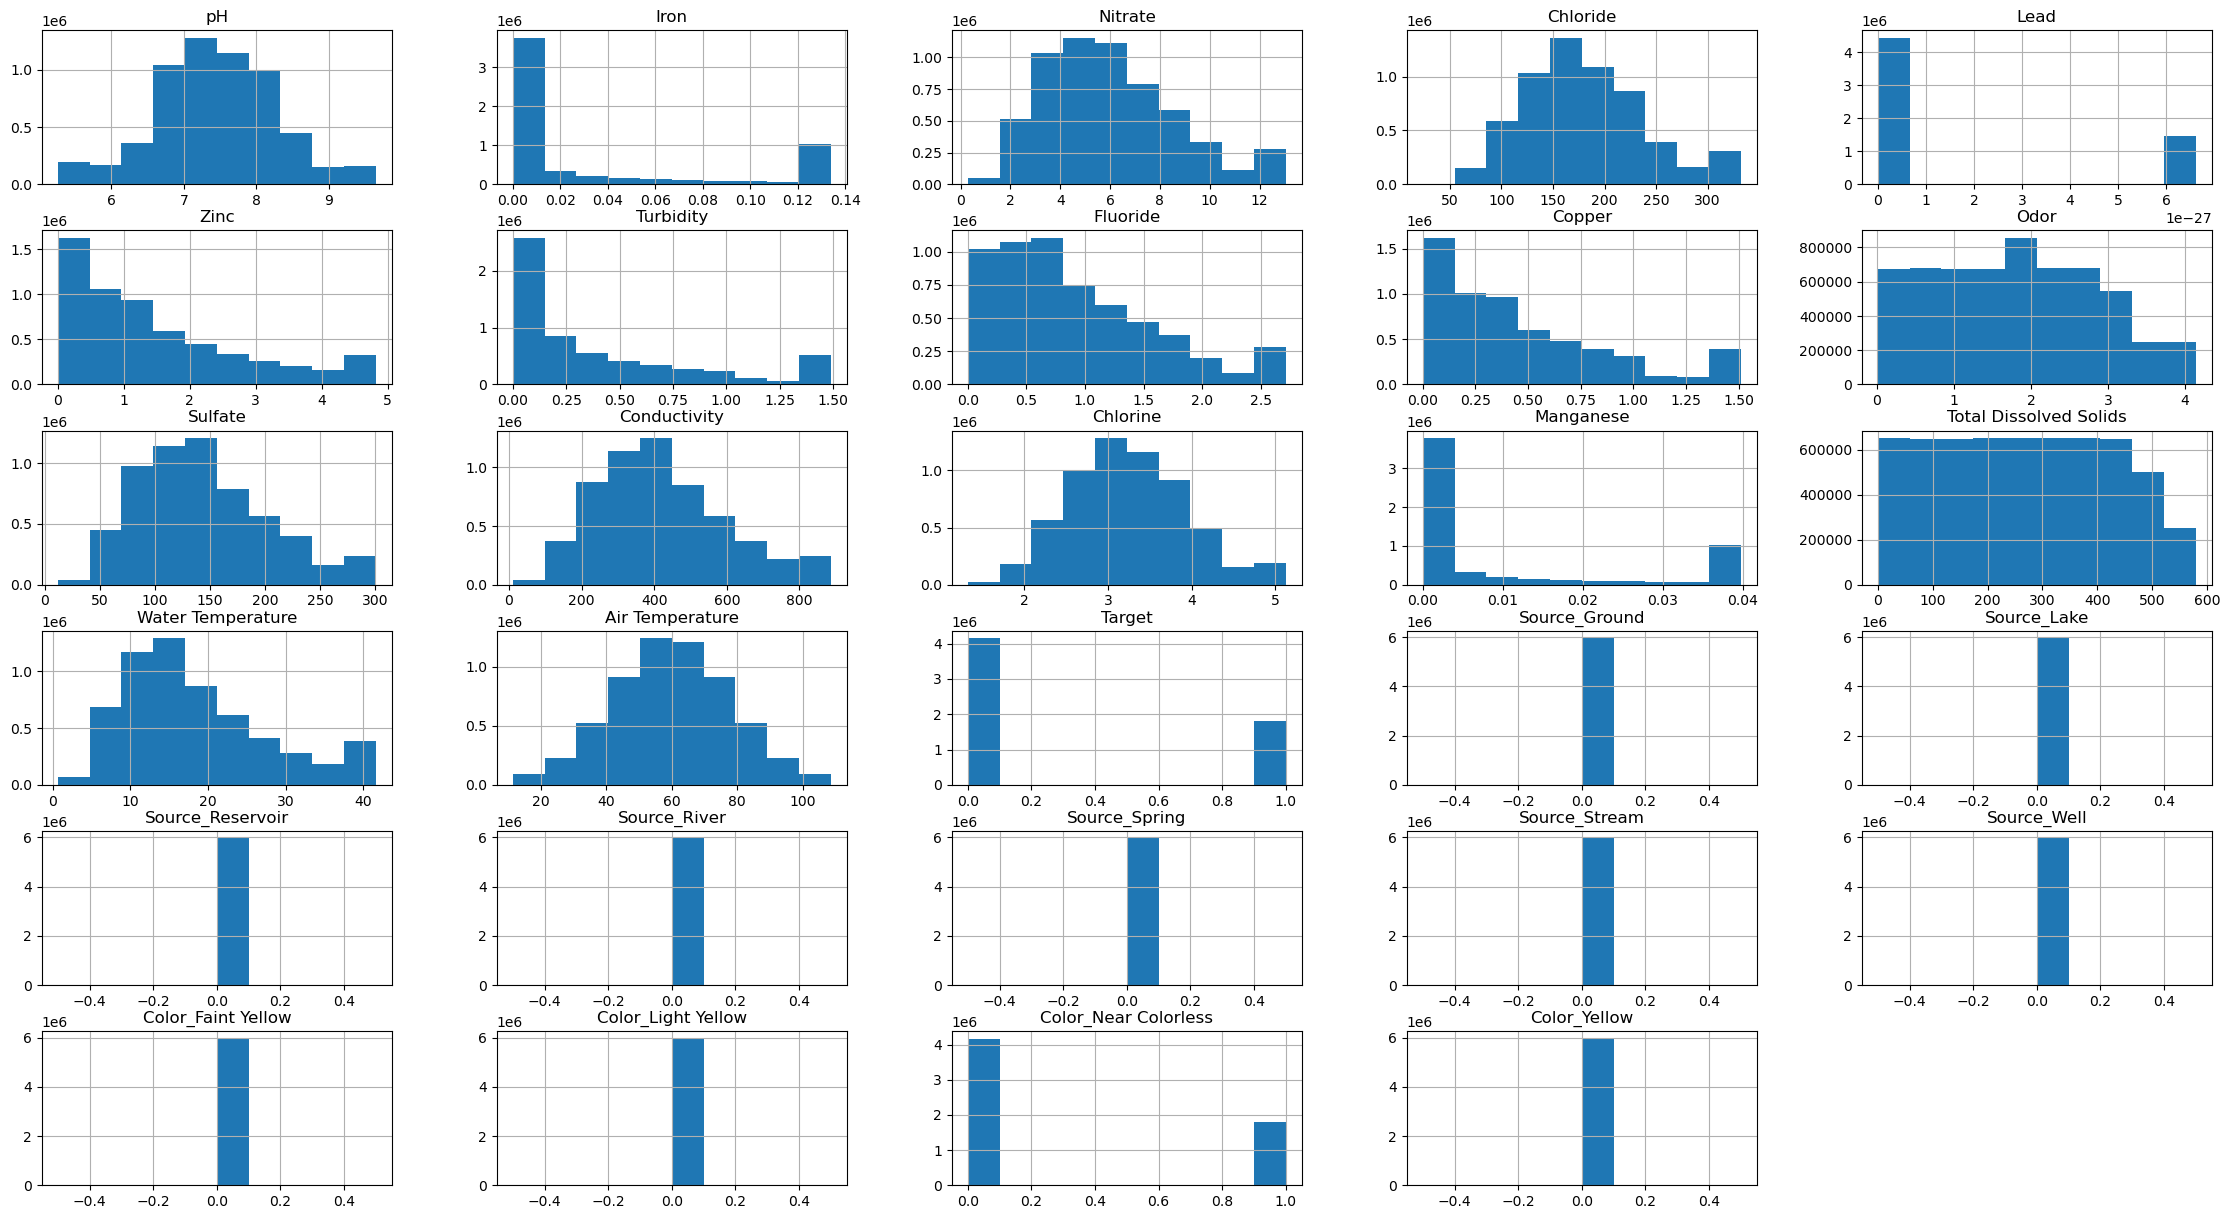

In [30]:
# Plot histograms for all columns in the data_encoded
plt.rcParams['figure.figsize'] = [28,15]
data_encoded.hist()
plt.show()

## Rescaling data

In [31]:
# Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data_encoded.drop('Target', axis=1))

# ML Application

# PCA

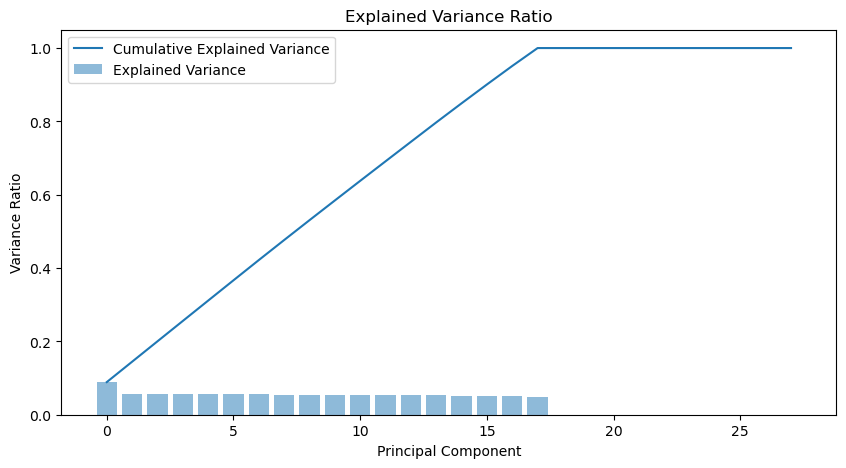

In [32]:
# Applying PCA
pca = PCA()
pca_features = pca.fit_transform(scaled_features)

# Plotting the Explained Variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(10,5))
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, label='Explained Variance')
plt.plot(range(len(explained_variance)), cumulative_variance, label='Cumulative Explained Variance')
plt.xlabel('Principal Component')
plt.ylabel('Variance Ratio')
plt.title('Explained Variance Ratio')
plt.legend()
plt.show()


In [33]:
pca = PCA(n_components=scaled_features.shape[1])
pca.fit(scaled_features)

# Compute the cumulative explained variance ratio
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)


In [34]:
# Calculating the difference between subsequent explained variance ratios
diffs = np.diff(explained_variance)


# Finding the first position where the difference is less than or equal to 0
elbow_point = np.argmax(diffs <= 0)

# Adjusting for the 0-based index
optimal_n_components = elbow_point + 1

optimal_n_components


1

In [35]:
# Extracting column names from data_encoded dataframe
columns = data_encoded.drop('Target', axis=1).columns

In [36]:
# Perform PCA with the optimal number of components
pca = PCA(n_components=optimal_n_components)
pca.fit(scaled_features)
principal_components = pca.transform(scaled_features)

In [37]:
# Get names of the important features based on optimal features
important_features = columns[pca.components_[0].argsort()[::-1][:optimal_n_components]]

# Create a DataFrame with only the important features
df_important_features = data_encoded[important_features]

print(important_features)
print(df_important_features.head())


Index(['Manganese'], dtype='object')
      Manganese
0  2.269945e-15
1  8.024076e-07
2  3.975649e-02
3  2.468295e-02
4  3.296139e-03


In [39]:
# Calculate absolute sum of loadings for each feature across optimal components
loadings_sum = np.abs(pca.components_[:optimal_n_components]).sum(axis=0)

# Sort the features based on the loading sums
sorted_idx = loadings_sum.argsort()[::-1]

# Get the important feature names
important_features = columns[sorted_idx]
df_important_features = data_encoded[important_features]

# Display results
print(important_features)
print('~' * 100)
print(df_important_features.head())

Index(['Manganese', 'Turbidity', 'Copper', 'Chloride', 'Odor', 'Nitrate',
       'Fluoride', 'Chlorine', 'Color_Near Colorless', 'Iron', 'Sulfate',
       'Total Dissolved Solids', 'Zinc', 'pH', 'Lead', 'Water Temperature',
       'Air Temperature', 'Conductivity', 'Source_Ground', 'Source_Lake',
       'Source_Reservoir', 'Source_River', 'Source_Spring', 'Source_Stream',
       'Source_Well', 'Color_Faint Yellow', 'Color_Light Yellow',
       'Color_Yellow'],
      dtype='object')
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
      Manganese  Turbidity    Copper    Chloride      Odor   Nitrate  \
0  2.269945e-15   0.022683  0.144599  122.799772  1.626212  8.605777   
1  8.024076e-07   0.019007  0.437835  227.029851  1.686049  3.734167   
2  3.975649e-02   0.319956  0.431588  230.995630  3.414619  3.816994   
3  2.468295e-02   0.166319  0.239451  178.129940  1.774284  8.224944   
4  3.296139e-03   0.004867  0.616574  186.540872  0.

In [40]:
# Separating data based on target values
class_0 = df_important_features[data_encoded['Target'] == 0]
class_1 = df_important_features[data_encoded['Target'] == 1]

# Sample 25000 instances from each class
sample_0 = class_0.sample(25000, random_state=42)
sample_1 = class_1.sample(25000, random_state=42)

# Concatenate the samples to create a balanced dataset
balanced_data = pd.concat([sample_0, sample_1], axis=0)

# Shuffling the data
balanced_data = balanced_data.sample(frac=1, random_state=42)

# Separate the features and target
X_balanced = balanced_data
y_balanced = data_encoded.loc[balanced_data.index, 'Target']

print(X_balanced.shape)
print(y_balanced.value_counts())


(50000, 28)
1.0    25000
0.0    25000
Name: Target, dtype: int64


## Train Test Model

In [41]:
# Splitting the balanced data
X_train_bal, X_temp_bal, y_train_bal, y_temp_bal = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)
X_val_bal, X_test_bal, y_val_bal, y_test_bal = train_test_split(X_temp_bal, y_temp_bal, test_size=0.5, random_state=42)

In [42]:
# Scaling the balanced data
scaler_bal = StandardScaler()
X_train_bal_scaled = scaler_bal.fit_transform(X_train_bal)
X_val_bal_scaled = scaler_bal.transform(X_val_bal)

# Logistic Regression

In [43]:
# Initialize the logistic regression model
logreg = LogisticRegression(max_iter=10000)

# Train the model
logreg.fit(X_train_bal_scaled, y_train_bal)

# Predict on the validation set
y_val_pred = logreg.predict(X_val_bal_scaled)

# Check the performance using classification report
report = classification_report(y_val_bal, y_val_pred)
print(report)

# Additionally, you can check accuracy
accuracy = accuracy_score(y_val_bal, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")


              precision    recall  f1-score   support

         0.0       0.75      0.79      0.77      3755
         1.0       0.78      0.74      0.76      3745

    accuracy                           0.76      7500
   macro avg       0.76      0.76      0.76      7500
weighted avg       0.76      0.76      0.76      7500

Validation Accuracy: 76.32%


# Grid search for hyperparameter tuning of a logistic regression model using cross-validation

In [44]:
# Define the hyperparameters and their values
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'class_weight': ['balanced', None]
}

# Initialize the logistic regression model
logreg = LogisticRegression(solver='saga', max_iter=10000)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_bal_scaled, y_train_bal)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")

# Evaluate the best model on the validation set
best_model = grid_search.best_estimator_
val_score = best_model.score(X_val_bal_scaled, y_val_bal)
print(f"Validation accuracy of best model: {val_score:.4f}")


Best parameters: {'C': 0.01, 'class_weight': None, 'penalty': 'l2'}
Best cross-validation score: 0.7593
Validation accuracy of best model: 0.7632


In [45]:
X_test_bal_scaled = scaler_bal.transform(X_test_bal)
test_score = best_model.score(X_test_bal_scaled, y_test_bal)
print(f"Test accuracy of best model: {test_score:.4f}")

Test accuracy of best model: 0.7503


# Random Forest Classifier, SVC & MLP Classifier

In [46]:
# Define the models
random_forest = RandomForestClassifier()
svm = SVC()
mlp = MLPClassifier()

In [ ]:
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
# Training and evaluating Random Forest
random_forest.fit(X_train_bal_scaled, y_train_bal)
y_pred_rf = random_forest.predict(X_val_bal_scaled)
print("Random Forest Metrics:")
print(f"Accuracy: {accuracy_score(y_val_bal, y_pred_rf):.4f}")
print(f"Precision: {precision_score(y_val_bal, y_pred_rf):.4f}")
print(f"Recall: {recall_score(y_val_bal, y_pred_rf):.4f}")
print(f"F1 Score: {f1_score(y_val_bal, y_pred_rf):.4f}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


# Training and evaluating SVM
svm.fit(X_train_bal_scaled, y_train_bal)
y_pred_svm = svm.predict(X_val_bal_scaled)
print("Support Vector Machine Metrics:")
print(f"Accuracy: {accuracy_score(y_val_bal, y_pred_svm):.4f}")
print(f"Precision: {precision_score(y_val_bal, y_pred_svm):.4f}")
print(f"Recall: {recall_score(y_val_bal, y_pred_svm):.4f}")
print(f"F1 Score: {f1_score(y_val_bal, y_pred_svm):.4f}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


# Training and evaluating MLP
mlp.fit(X_train_bal_scaled, y_train_bal)
y_pred_mlp = mlp.predict(X_val_bal_scaled)
print("Multi-layer Perceptron Metrics:")
print(f"Accuracy: {accuracy_score(y_val_bal, y_pred_mlp):.4f}")
print(f"Precision: {precision_score(y_val_bal, y_pred_mlp):.4f}")
print(f"Recall: {recall_score(y_val_bal, y_pred_mlp):.4f}")
print(f"F1 Score: {f1_score(y_val_bal, y_pred_mlp):.4f}")
print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Random Forest Metrics:
Accuracy: 0.8931
Precision: 0.8508
Recall: 0.9530
F1 Score: 0.8990
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Support Vector Machine Metrics:
Accuracy: 0.8577
Precision: 0.8419
Recall: 0.8804
F1 Score: 0.8607
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~


In [ ]:
# Compute metrics for Logistic Regression
logreg_accuracy = accuracy_score(y_val_bal, best_model.predict(X_val_bal_scaled))
logreg_precision = precision_score(y_val_bal, best_model.predict(X_val_bal_scaled))
logreg_recall = recall_score(y_val_bal, best_model.predict(X_val_bal_scaled))
logreg_f1_score = f1_score(y_val_bal, best_model.predict(X_val_bal_scaled))

# Compute metrics for Random Forest
y_pred_rf = random_forest.predict(X_val_bal_scaled)
random_forest_accuracy = accuracy_score(y_val_bal, y_pred_rf)
random_forest_precision = precision_score(y_val_bal, y_pred_rf)
random_forest_recall = recall_score(y_val_bal, y_pred_rf)
random_forest_f1_score = f1_score(y_val_bal, y_pred_rf)

# Compute metrics for SVM
y_pred_svm = svm.predict(X_val_bal_scaled)
svm_accuracy = accuracy_score(y_val_bal, y_pred_svm)
svm_precision = precision_score(y_val_bal, y_pred_svm)
svm_recall = recall_score(y_val_bal, y_pred_svm)
svm_f1_score = f1_score(y_val_bal, y_pred_svm)

# Compute metrics for MLP
y_pred_mlp = mlp.predict(X_val_bal_scaled)
mlp_accuracy = accuracy_score(y_val_bal, y_pred_mlp)
mlp_precision = precision_score(y_val_bal, y_pred_mlp)
mlp_recall = recall_score(y_val_bal, y_pred_mlp)
mlp_f1_score = f1_score(y_val_bal, y_pred_mlp)

# Plotting the metrics
plt.figure(figsize=(10, 6))  # Set the figure size
plt.plot(['Logistic Regression','Random Forest', 'SVM', 'MLP'], [logreg_accuracy, random_forest_accuracy, svm_accuracy, mlp_accuracy], label='Accuracy')
plt.plot(['Logistic Regression','Random Forest', 'SVM', 'MLP'], [logreg_precision, random_forest_precision, svm_precision, mlp_precision], label='Precision')
plt.plot(['Logistic Regression','Random Forest', 'SVM', 'MLP'], [logreg_recall, random_forest_recall, svm_recall, mlp_recall], label='Recall')
plt.plot(['Logistic Regression','Random Forest', 'SVM', 'MLP'], [logreg_f1_score, random_forest_f1_score, svm_f1_score, mlp_f1_score], label='F1-score')
plt.xlabel('Model', fontsize=12, fontweight='bold')  # Set the font size and weight for xlabel
plt.ylabel('Metric', fontsize=12, fontweight='bold')  # Set the font size and weight for ylabel
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')  # Set the font size and weight for title
plt.legend()
plt.show()


## Hyperparameter tuning for the RandomForestClassifier using GridSearchCV

In [ ]:
# Hypertuning the parameters using Grid CV
# Define the hyperparameters and their values
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

# Initialize the random forest model
random_forest = RandomForestClassifier()

# Initialize the GridSearchCV object
grid_search = GridSearchCV(random_forest, param_grid, cv=5, n_jobs=-1)

# Fit the model to the training data
grid_search.fit(X_train_bal_scaled, y_train_bal)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validation score: {best_score:.4f}")


## To reduce execution time for hyperparameter tuning, we can use the following strategies:

# Make predictions on the test set

In [ ]:
# Use the best estimator from the grid search to make predictions
y_val_pred = grid_search.best_estimator_.predict(X_val_bal_scaled)

# Evaluate the model's performance on the validation set
val_accuracy = accuracy_score(y_val_bal, y_val_pred)
val_precision = precision_score(y_val_bal, y_val_pred)
val_recall = recall_score(y_val_bal, y_val_pred)
val_f1 = f1_score(y_val_bal, y_val_pred)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1-score: {val_f1:.4f}")


In [ ]:
# Make predictions on the test set
# Random Forest model

random_forest_preds = grid_search.predict(X_val_bal_scaled)

# Use the best parameters
best_params = {'max_depth': 7, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
rf_model = RandomForestClassifier(**best_params)

# Train the model
rf_model.fit(X_train_bal_scaled, y_train_bal)

# Predicting the data
rf_preds = rf_model.predict(X_val_bal_scaled)  # Replace X_new_data with your new/test data

# Evaluate the models

# Random Forest model
rf_accuracy = accuracy_score(y_val_bal, rf_preds)
rf_precision = precision_score(y_val_bal, rf_preds)
rf_recall = recall_score(y_val_bal, rf_preds)
rf_f1_score = f1_score(y_val_bal, rf_preds)

# Print the results
print('Random Forest')
print('Accuracy:', rf_accuracy)
print('Precision:', rf_precision)
print('Recall:', rf_recall)
print('F1-score:', rf_f1_score)


## Display the feature importance of the Random Forest model

In [ ]:
# Getting feature importances from the best trained model
importances = grid_search.best_estimator_.feature_importances_
indices = np.argsort(importances)[::-1]

# Displaying important features
for f in range(X_train_bal_scaled.shape[1]):
    print(f"{X_balanced.columns[indices[f]]}: {importances[indices[f]]}")


In [ ]:
# Coefficients from Logistic Regression
# Instantiate and fit the logistic regression model
logreg = LogisticRegression()
logreg.fit(X_train_bal_scaled, y_train_bal)

# Displaying coefficients
for coef, feat in zip(logreg.coef_[0], X_balanced.columns):
    print(f"{feat}: {coef}")
    

## Decision Tree Visualization for Thresholds

In [ ]:
# Decision Tree Visualization for Thresholds

tree = DecisionTreeClassifier(max_depth=3)
tree.fit(X_train_bal_scaled, y_train_bal)

plt.figure(figsize=(20,10))
plot_tree(tree, filled=True, feature_names=list(X_balanced.columns), class_names=['0','1'])
plt.show()


## ROC Curve Analysis for Feature Threshold

In [ ]:
# ROC Curve Analysis for Feature Threshold
def find_optimal_threshold(feature_values, target):
    thresholds = sorted(np.unique(feature_values))
    tprs = []
    fprs = []

    for thresh in thresholds:
        prediction = [1 if f > thresh else 0 for f in feature_values]
        fpr, tpr, _ = roc_curve(target, prediction)
        tprs.append(tpr[1])
        fprs.append(fpr[1])

    return thresholds[np.argmax([tpr - fpr for tpr, fpr in zip(tprs, fprs)])]

# Convert the scaled numpy array back to DataFrame
X_val_bal_df = pd.DataFrame(X_val_bal_scaled, columns=X_balanced.columns)

# Testing on a feature
feature_name = 'Total Dissolved Solids'
optimal_threshold = find_optimal_threshold(X_val_bal_df[feature_name].values, y_val_bal)
print(f"Optimal threshold for {feature_name}: {optimal_threshold}")


## Empirical Cumulative Distribution Function (ECDF)

In [ ]:
def plot_ecdf(feature, target, feature_name):
    plt.figure(figsize=(10, 7))
    sns.ecdfplot(data=X_balanced[y_balanced==0], x=feature, label='Class 0')
    sns.ecdfplot(data=X_balanced[y_balanced==1], x=feature, label='Class 1')
    plt.title(f'ECDF of {feature_name}')
    plt.legend()
    plt.show()

# Test on a feature
plot_ecdf(X_balanced[feature_name], y_balanced, feature_name)


In [ ]:
for feature in X_balanced.columns:
    stat, p = mannwhitneyu(X_balanced[y_balanced==0][feature], X_balanced[y_balanced==1][feature])
    if p < 0.05:
        print(f"{feature} has a significant difference between classes with p-value {p:.4f}")
    else:
        print(f"{feature} does not show significant difference between classes.")


## Define All Features

In [ ]:
# Get the list of all features from the dataset
all_features = X_balanced.columns

thresholds_dict = {}

for feature in all_features:
    optimal_threshold = find_optimal_threshold(X_val_bal_df[feature].values, y_val_bal)
    thresholds_dict[feature] = optimal_threshold
    print(f"Optimal threshold for {feature}: {optimal_threshold}")

# To access the thresholds later
for feature, threshold in thresholds_dict.items():
    print(f"{feature}: {threshold}")


In [ ]:
X_balanced.head()

In [ ]:
# Create a dictionary to store the original thresholds
original_thresholds = {}

for feature, scaled_threshold in thresholds_dict.items():
    mean = scaler_bal.mean_[X_balanced.columns.get_loc(feature)]
    std_dev = np.sqrt(scaler_bal.var_[X_balanced.columns.get_loc(feature)])
    
    # Convert scaled threshold to original value
    original_threshold = (scaled_threshold * std_dev) + mean
    
    original_thresholds[feature] = original_threshold
    print(f"Optimal threshold for {feature}: {original_threshold}")


In [ ]:
# Instantiate the model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(X_balanced, y_balanced)

# Now, you can access feature_importances_
importances = random_forest.feature_importances_

# Plotting the feature importances
plt.figure(figsize=(15, 10))
indices = np.argsort(importances)[::-1]
plt.title("Feature importances from trained Random Forest")
plt.bar(range(X_balanced.shape[1]), importances[indices], align="center")
plt.xticks(range(X_balanced.shape[1]), X_balanced.columns[indices], rotation=90)
plt.xlim([-1, X_balanced.shape[1]])
plt.show()


## Decision boundary

In [ ]:
def find_decision_boundary(feature_name, model, X, step_size=0.01):
    # Extract median values of all features
    median_values = X.median().to_dict()
    
    # Create a range of synthetic values for the feature of interest
    feature_range = np.arange(X[feature_name].min(), X[feature_name].max(), step_size)
    
    # Placeholder for the predictions
    predictions = []

    for value in feature_range:
        # Create a synthetic sample
        sample = median_values.copy()
        sample[feature_name] = value
        sample_df = pd.DataFrame([sample])
        
        # Predict the classification for the synthetic sample
        prediction = model.predict(sample_df)[0]
        predictions.append(prediction)

    # Identify the boundary by looking for points where the prediction changes
    decision_boundaries = [feature_range[i] for i in range(1, len(predictions)) if predictions[i] != predictions[i - 1]]

    return decision_boundaries


feature_name = 'Total Dissolved Solids'
boundaries = find_decision_boundary(feature_name, rf_model, X_balanced)  # assuming rf_model is your Random Forest model
print(f"Decision boundaries for {feature_name}: {boundaries}")


In [ ]:
# !pip install -U scikit-learn
# !pip install flask

In [ ]:
with open("random_forest.pkl", "wb") as model_file:
    pickle.dump(random_forest, model_file)


In [ ]:
# Define the international standards
quantitative_columns=['Manganese', 'Turbidity', 'Copper', 'Chloride', 'Nitrate',
       'Fluoride', 'Chlorine', 'Iron', 'Sulfate', 'Total Dissolved Solids',
       'Zinc', 'Lead',]
standards = {
    'Manganese': 0.05,  # mg/L - Maximum acceptable concentration
    'Turbidity': 5,     # NTU - (However, for drinking water it's usually below 1 NTU)
    'Copper': 1.3,      # mg/L - Maximum Contaminant Level (MCL)
    'Chloride': 250,    # mg/L - Suggested upper limit
    'Nitrate': 50,      # mg/L as NO3 (10 mg/L if measured as Nitrate-Nitrogen)
    'Fluoride': 1.5,    # mg/L - Maximum allowable concentration
    'Chlorine': 4,      # mg/L - Maximum residual disinfectant level
    'Iron': 0.3,        # mg/L - Suggested upper limit
    'Sulfate': 250,     # mg/L - Suggested upper limit
    'Total Dissolved Solids': 1000, # mg/L - Recommended maximum
    'Zinc': 5,          # mg/L - Recommended maximum
    'Lead': 0.01,       # mg/L - Action level (often the goal is to have as little as possible)
}


# Calculate the distance from standards for each feature
distances = X_balanced[quantitative_columns] - standards

# Normalize the distances between 0 and 1
normalized_distances = (distances - distances.min()) / (distances.max() - distances.min())

# Calculate WQI for each data point
WQI = (1 - normalized_distances.mean(axis=1)) * 100

In [ ]:
X_balanced.head()

In [ ]:
norm_importances=importances / sum(importances)

In [ ]:
norm_importances

In [ ]:
important_features

In [ ]:
# Convert lists to dictionary
feature_importance_dict = dict(zip(important_features, importances))

# Ensure the importance values are normalized
total_importance = sum(feature_importance_dict.values())
for feature in feature_importance_dict:
    feature_importance_dict[feature] /= total_importance

# Calculate the weighted distances
distances = []

for index, row in X_balanced.iterrows():
    distance = 0
    for feature, importance in feature_importance_dict.items():
        standard = standards.get(feature)
        if standard is not None:  # Skip features with no direct numeric standard
            distance += importance * abs(row[feature] - standard)
    distances.append(distance)

# Normalize the distances to get an index between 0 and 100
max_distance = max(distances)
min_distance = min(distances)
scaled_distances = [(d - min_distance)/(max_distance - min_distance) * 100 for d in distances]

# Convert the scaled distances to an index value where lower values indicate better quality (closer to the standard)
quality_index = [100 - d for d in scaled_distances]


In [ ]:
X_balanced['Weighted QI']=quality_index
X_balanced['Class']=y_balanced

X = X_balanced[important_features]
y = data_encoded.loc[balanced_data.index, 'Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred_gb)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1-score
print(classification_report(y_test, y_pred_gb))

# ROC-AUC score
y_prob_gb = gb.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_prob_gb)
print(f"ROC-AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob_gb)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


In [ ]:
y_pred_gbs = gb.predict(X)
y_pred_gbs

In [ ]:
X_balanced['Boosted_Prob_class']=y_pred_gbs
X_balanced.head()

In [ ]:
y_true = np.array(X_balanced['Class'])  # actual labels
y_probs = np.array(X_balanced['Boosted_Prob_class'])  # predicted probabilities

# Confusion Matrix
cm = confusion_matrix(y_true, (y_probs > 0.5).astype(int))
print("Confusion Matrix:")
print(cm)

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_probs)
plt.figure()
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# Histogram of Predicted Probabilities
plt.figure()
plt.hist(y_probs, bins=10, edgecolor='k', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Histogram of Predicted Probabilities')
plt.show()

# Calibration Plot
prob_true, prob_pred = calibration_curve(y_true, y_probs, n_bins=10)
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(prob_pred, prob_true, "s-")
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plot")
plt.show()


In [ ]:
# maximum 'Weighted QI' value for the samples that belong to class 0.

X_balanced[X_balanced['Class']==0]['Weighted QI'].max()

In [ ]:
# Assuming df is your dataframe with columns: 'feature_importance', 'true_label', 'predicted_prob'
df = pd.DataFrame({
     'feature_importance': X_balanced['Weighted QI'],
     'true_label': X_balanced['Class'],
     'predicted_prob': X_balanced['Boosted_Prob_class']
})

# 1. Visualize the Data:

# Scatter Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='feature_importance', y='predicted_prob', hue='true_label', data=df)
plt.title("Scatter Plot of Feature Importance vs Predicted Probability")
plt.show()

# Box Plot
plt.figure(figsize=(10,6))
sns.boxplot(x='true_label', y='predicted_prob', data=df)
plt.title("Box Plot of Predicted Probabilities for each Class")
plt.show()

# 2. Correlation Analysis:
correlation, _ = pearsonr(df['feature_importance'], df['predicted_prob'])
print(f"Correlation between feature importance and predicted probability: {correlation:.2f}")

# 3. Evaluate the Model by Subsetting Data:
median_importance = df['feature_importance'].median()
subset_1 = df[df['feature_importance'] < median_importance]
subset_2 = df[df['feature_importance'] >= median_importance]

accuracy_1 = (subset_1['true_label'] == (subset_1['predicted_prob'] > 0.5).astype(int)).mean()
accuracy_2 = (subset_2['true_label'] == (subset_2['predicted_prob'] > 0.5).astype(int)).mean()

print(f"Accuracy for subset with feature importance < median: {accuracy_1:.2f}")
print(f"Accuracy for subset with feature importance >= median: {accuracy_2:.2f}")

# 4. Aggregate Analysis:
bins = pd.cut(df['feature_importance'], 10)  # Creating 10 bins
grouped = df.groupby(bins)['predicted_prob'].mean()

plt.figure(figsize=(10,6))
grouped.plot(kind='bar')
plt.title("Average Predicted Probability for Bins of Feature Importance")
plt.ylabel("Average Predicted Probability")
plt.show()

# 5. Conditional Distribution:
prob_bins = pd.cut(df['predicted_prob'], [0, 0.2, 0.4, 0.6, 0.8, 1.0])
conditional_dist = df.groupby(prob_bins)['true_label'].mean()

plt.figure(figsize=(10,6))
conditional_dist.plot(kind='bar')
plt.title("Fraction of True Class 1 for Ranges of Predicted Probabilities")
plt.ylabel("Fraction of Class 1")
plt.show()

# 6. Error Analysis:
errors = df[df['true_label'] != (df['predicted_prob'] > 0.5).astype(int)]
sns.histplot(errors['feature_importance'], bins=30, kde=True)
plt.title("Distribution of Feature Importance for Misclassifications")
plt.show()

In [ ]:
data = {
    'feature_importance': X_balanced['Weighted QI'], 
    'target': X_balanced['Class']
} 

df = pd.DataFrame(data)

# Define bins for feature importance
bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

# Create a new column in the dataframe for the bins
df['feature_importance_bins'] = pd.cut(df['feature_importance'], bins)

# Group by the bins and compute the mean target value for each bin
mean_target_per_bin = df.groupby('feature_importance_bins')['target'].mean()

print(mean_target_per_bin)


In [ ]:
# Assuming df is already defined with the given structure

# Aggregate Analysis:
bins = pd.cut(df['feature_importance'], 10)  # Creating 10 bins
grouped = df.groupby(bins)['target'].median()

plt.figure(figsize=(10,6))
grouped.plot(kind='bar')
plt.title("Median Target Value for Bins of Feature Importance")
plt.ylabel("Median Target value")
plt.show()


In [ ]:
X_balanced[X_balanced['Weighted QI']>60].head()

In [ ]:
# Identify rows above cut-off (WQI > 70) and with Class = 1
above_cutoff = X_balanced[(X_balanced['Weighted QI'] > 70) & (X_balanced['Class'] == 1)]

In [ ]:
# Identify rows above cut-off (WQI > 70) with Class = 1 and Predicted Probability Class = 1
perc_accurate_preds=len(above_cutoff[above_cutoff['Boosted_Prob_class']==1])*100/len(above_cutoff)

In [ ]:
accurate_preds = above_cutoff[above_cutoff['Boosted_Prob_class'] > 0.5]
perc_accurate_preds = len(accurate_preds) * 100 / len(above_cutoff)


In [ ]:
# Percentage accuracy in prediction of class using Probability
perc_accurate_preds

In [ ]:
plt.scatter(X_balanced['Weighted QI'], X_balanced['Class'], c='blue', label='Actual Class')
# assuming a column 'predicted_probabilities' in your dataframe
plt.scatter(X_balanced['Weighted QI'], X_balanced['Boosted_Prob_class'], c='red', label='Predicted Probabilities')
plt.xlabel('Weighted QI')
plt.ylabel('Value')
plt.legend()
plt.show()


In [ ]:
correlation = X_balanced['Class'].corr(X_balanced['Boosted_Prob_class'])
print(f"Correlation between feature_importance and Class: {correlation}")


In [ ]:
# Assuming 'predicted_probabilities' is the model's predicted probabilities for Class=1
fpr, tpr, thresholds = roc_curve(X_balanced['Class'], X_balanced['Boosted_Prob_class'])
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()
